# AlertaBayan: Flood Risk Assessment Pipeline for Metro Manila Barangays
## Defense-Ready Reproducible Notebook

> **Critical caveat — Proxy Labels, No Ground Truth**
>
> This pipeline uses *proxy labels* derived from a deterministic index (DPI).
> There are **no external ground-truth** flood outcome labels in the dataset.
> All supervised performance metrics measure **agreement with DPI** — not
> real-world flood prediction accuracy. See the Methodology document for the
> full limitations discussion.

**Pipeline stages**:
1. **Data Integration** — NOAH flood hazard layers + PSA 2020 Census
2. **Feature Engineering** — exposure ratios, density, interaction terms
3. **Deterministic Benchmarking** — CSI, Vulnerability Score, DPI, risk classes
4. **Unsupervised Profiling** — K-Means risk archetypes
5. **Supervised Benchmarking** — classification + regression of DPI-derived targets
6. **Sensitivity Analysis & Validation** — weight robustness, construct validation

## 1. Environment Setup

In [ ]:
# Sorted Imports 
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from fpdf import FPDF, XPos, YPos
from scipy.stats import spearmanr
from sklearn.base import clone
from sklearn.cluster import KMeans
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import (
    GradientBoostingClassifier, GradientBoostingRegressor,
    RandomForestClassifier, RandomForestRegressor,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score, adjusted_rand_score, balanced_accuracy_score,
    calinski_harabasz_score, confusion_matrix, davies_bouldin_score,
    f1_score, mean_absolute_error, mean_squared_error, silhouette_score,
)
from sklearn.model_selection import (
    GroupKFold, KFold, StratifiedKFold, cross_val_score, train_test_split,
)
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

# Display settings 
%matplotlib inline
plt.rcParams.update({'figure.dpi': 120, 'savefig.dpi': 150, 'savefig.bbox': 'tight'})
sns.set_style('whitegrid')
sns.set_palette('colorblind')
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 140)

# Package versions 
import sklearn as _sk, scipy as _sp, matplotlib as _mpl
for _name, _mod in [('pandas', pd), ('numpy', np), ('scikit-learn', _sk),
                     ('scipy', _sp), ('matplotlib', _mpl), ('seaborn', sns)]:
    print(f'{_name:15s} {_mod.__version__}')

KeyboardInterrupt: 

In [ ]:
# Global seed
RANDOM_STATE = 42

# Canonical model display names (single source of truth) 
MODEL_NAMES = {
    "dummy_clf":  "Dummy (Majority Class)",
    "logreg":     "Logistic Regression",
    "dt2":        "Shallow Decision Tree",
    "ord_ridge":  "Ordinal Ridge (rounded)",
    "rf":         "Random Forest",
    "gb":         "Gradient Boosting",
    "mlp":        "Neural Network (MLP)",
    "dummy_reg":  "Dummy (Mean Predictor)",
    "ridge_reg":  "Ridge Regression",
}

BASELINE_CLF_NAMES = {MODEL_NAMES[k] for k in ("dummy_clf", "logreg", "dt2", "ord_ridge")}
BASELINE_REG_NAMES = {MODEL_NAMES[k] for k in ("dummy_reg", "ridge_reg")}

# Feature columns used for modeling 
FEATURE_COLS = [
    'Pop_Density', 'flood5_coverage', 'flood100_coverage',
    'Affected_Pop_100yr', 'Flood_Growth_5to25', 'Land Area',
]

# Pipeline builder 
def make_preprocess_pipe(estimator):
    """Imputer -> Scaler -> Model pipeline (prevents train/test leakage)."""
    return Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler',  StandardScaler()),
        ('model',   estimator),
    ])

# Model factories (fresh unfitted copies)
def get_baseline_clf_models():
    return {
        MODEL_NAMES["dummy_clf"]: make_preprocess_pipe(DummyClassifier(strategy="most_frequent")),
        MODEL_NAMES["logreg"]:    make_preprocess_pipe(LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
        MODEL_NAMES["dt2"]:       make_preprocess_pipe(DecisionTreeClassifier(max_depth=2, random_state=RANDOM_STATE)),
        MODEL_NAMES["ord_ridge"]: make_preprocess_pipe(Ridge(alpha=1.0)),
    }

def get_primary_clf_models():
    return {
        MODEL_NAMES["rf"]:  make_preprocess_pipe(RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)),
        MODEL_NAMES["gb"]:  make_preprocess_pipe(GradientBoostingClassifier(random_state=RANDOM_STATE)),
        MODEL_NAMES["mlp"]: make_preprocess_pipe(MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=3000, random_state=RANDOM_STATE)),
    }

def get_baseline_reg_models():
    return {
        MODEL_NAMES["dummy_reg"]: make_preprocess_pipe(DummyRegressor(strategy="mean")),
        MODEL_NAMES["ridge_reg"]: make_preprocess_pipe(Ridge(alpha=1.0)),
    }

def get_primary_reg_models():
    return {
        MODEL_NAMES["rf"]:  make_preprocess_pipe(RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE)),
        MODEL_NAMES["gb"]:  make_preprocess_pipe(GradientBoostingRegressor(random_state=RANDOM_STATE)),
        MODEL_NAMES["mlp"]: make_preprocess_pipe(MLPRegressor(hidden_layer_sizes=(32, 16), max_iter=3000, random_state=RANDOM_STATE)),
    }

# Scoring helper functions
def get_vuln_score(density):
    """Vulnerability score from population density (ppl/m2). Range 0-10."""
    if pd.isna(density) or density <= 0.0: return 0
    if density >= 0.07: return 10
    if density >= 0.04: return 7
    if density >= 0.02: return 4
    return 2

def get_flood_score(ratio):
    """Flood risk score from coverage ratio. Range 0-10."""
    if pd.isna(ratio): return 0
    if ratio >= 0.80: return 10.0
    if ratio >= 0.50: return 7.5
    if ratio >= 0.20: return 5.0
    if ratio > 0.05:  return 2.5
    return 0.0

def dpi_to_risk_class(dpi_score):
    """Convert continuous DPI to ordinal risk class."""
    if pd.isna(dpi_score): return 'Low'
    if dpi_score >= 6.5: return 'High'
    if dpi_score >= 3.5: return 'Moderate'
    return 'Low'

ORDINAL_MAP = {'Low': 0, 'Moderate': 1, 'High': 2}
INVERSE_ORDINAL_MAP = {v: k for k, v in ORDINAL_MAP.items()}

# Ordinal Ridge custom scorers for cross_val_score
def _ordinal_ridge_f1w(estimator, X_eval, y_eval):
    y_pred = np.clip(np.round(estimator.predict(X_eval)).astype(int), 0, 2)
    return f1_score(y_eval, y_pred, average='weighted', zero_division=0)

def _ordinal_ridge_f1m(estimator, X_eval, y_eval):
    y_pred = np.clip(np.round(estimator.predict(X_eval)).astype(int), 0, 2)
    return f1_score(y_eval, y_pred, average='macro', zero_division=0)

# Chart save helper
SAVED_FIGURES = []
def save_and_show(filename):
    """Save current figure to disk and display inline."""
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    SAVED_FIGURES.append(filename)
    plt.show()
    plt.close()

print("Configuration and helpers loaded.")

Configuration and helpers loaded.


## 2. Load Data

Load the combined Metro Manila flood-population CSV. The dataset integrates:
- **Geospatial hazard data**: DOST-Project NOAH flood layers (5yr, 25yr, 100yr return periods)
- **Demographic data**: PSA 2020 Census (population, land area at barangay level)

In [ ]:
CSV_PATH = 'MetroManila_Combined_Flood_Population.csv'

# Load & clean 
df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()

# Rename to canonical column names
rename_map = {
    'barangay': 'Name', 'Barangay': 'Name',
    'brgy_area_sqm': 'Land Area',
    'Population_2020': 'Population', 'population': 'Population', 'Population': 'Population',
}
df = df.rename(columns=rename_map)

if 'Name' not in df.columns:
    raise KeyError("Could not find 'Barangay' or 'Name' column. Check CSV headers.")
if 'Population' not in df.columns:
    print("WARNING: Population column missing. Creating empty column.")
    df['Population'] = 0

# Uniqueness check: composite key City + Barangay
if 'City' in df.columns:
    df['City_Name'] = df['City'].astype(str).str.strip() + '_' + df['Name'].astype(str).str.strip()
    n_total, n_unique = len(df), df['City_Name'].nunique()
    if n_total != n_unique:
        print(f"WARNING: {n_total - n_unique} duplicate City+Barangay entries. Keeping first.")
        df = df.drop_duplicates(subset='City_Name', keep='first').reset_index(drop=True)
    else:
        print(f"Uniqueness check passed: {n_unique} unique barangays.")

# Quick overview 
print(f"\nShape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
display(df.head(10))

Uniqueness check passed: 935 unique barangays.

Shape: (935, 9)
Columns: ['district', 'City', 'Name', 'Land Area', 'flood5_sqm_final', 'flood25_sqm_final', 'flood100_sqm_final', 'Population', 'City_Name']


,district,City,Name,Land Area,flood5_sqm_final,flood25_sqm_final,flood100_sqm_final,Population,City_Name
0,Metropolitan Manila First District,Manila,Barangay 1,49547.49,8264.85,21069.57,24194.32,2995,Manila_Barangay 1
1,Metropolitan Manila First District,Manila,Barangay 2,37885.97,5076.65,16510.82,27996.49,1887,Manila_Barangay 2
2,Metropolitan Manila First District,Manila,Barangay 3,38940.56,27962.09,37710.28,38350.78,1341,Manila_Barangay 3
3,Metropolitan Manila First District,Manila,Barangay 4,40193.69,9028.71,26647.36,37927.32,1691,Manila_Barangay 4
4,Metropolitan Manila First District,Manila,Barangay 5,24741.85,6958.36,17729.88,23759.84,1288,Manila_Barangay 5
5,Metropolitan Manila First District,Manila,Barangay 6,41515.27,32870.69,39915.27,41041.74,771,Manila_Barangay 6
6,Metropolitan Manila First District,Manila,Barangay 7,44040.72,20195.06,38556.59,42990.22,1560,Manila_Barangay 7
7,Metropolitan Manila First District,Manila,Barangay 8,36398.19,17894.78,29467.84,30433.46,147,Manila_Barangay 8
8,Metropolitan Manila First District,Manila,Barangay 9,12766.72,7660.55,12525.63,12567.18,447,Manila_Barangay 9
9,Metropolitan Manila First District,Manila,Barangay 10,6057.59,5544.13,5999.13,6033.96,160,Manila_Barangay 10


## 3. Data Quality Checks

Inspect missing values, impossible values (flood area > land area), and basic descriptive statistics.

In [ ]:
# Missing values table
miss = df.isnull().sum().rename('n_missing').to_frame()
miss['pct_missing'] = (miss['n_missing'] / len(df) * 100).round(2)
display(miss)

# Impossible values: flood area > land area
for flood_col in ['flood5_sqm_final', 'flood25_sqm_final', 'flood100_sqm_final']:
    n_over = (df[flood_col] > df['Land Area']).sum()
    print(f"  {flood_col} > Land Area: {n_over} rows")
n_zero_area = (df['Land Area'] == 0).sum()
print(f"  Zero Land Area rows: {n_zero_area}")

# Negative flood growth (data artifact)
n_neg_growth = (df['flood25_sqm_final'] < df['flood5_sqm_final']).sum()
print(f"  Negative flood growth (flood25 < flood5): {n_neg_growth} rows")

# City counts 
print(f"\nCities: {df['City'].nunique()}")
display(df['City'].value_counts().to_frame('count'))

,n_missing,pct_missing
district,0,0.0
City,0,0.0
Name,0,0.0
Land Area,0,0.0
flood5_sqm_final,0,0.0
flood25_sqm_final,0,0.0
flood100_sqm_final,0,0.0
Population,0,0.0
City_Name,0,0.0


  flood5_sqm_final > Land Area: 0 rows
  flood25_sqm_final > Land Area: 0 rows
  flood100_sqm_final > Land Area: 0 rows
  Zero Land Area rows: 0
  Negative flood growth (flood25 < flood5): 3 rows

Cities: 17


,count
City,
Manila,210
Caloocan,188
Quezon City,138
Pasay,128
Makati,33
Valenzuela,31
Pasig,29
Mandaluyong,27
Taguig,26


## 4. Feature Engineering

Compute exposure ratios, population density, interaction terms, and flood growth rate.
Features with `NaN` (from zero/missing land area) are preserved for downstream
`SimpleImputer` mean-imputation inside `Pipeline` objects.

In [ ]:
# Basic cleanup: zero land area → NaN 
n_zero = (df['Land Area'] == 0).sum()
n_null = df['Land Area'].isna().sum()
df['Land Area'] = df['Land Area'].replace(0, np.nan)
n_invalid = df['Land Area'].isna().sum()
if n_invalid:
    print(f"  Land Area: {n_zero} zero + {n_null} null = {n_invalid} invalid rows (will be imputed).")

# Flood coverage ratios (clipped to [0, 1])
df['flood5_coverage']   = np.clip(df['flood5_sqm_final']   / df['Land Area'], 0, 1)
df['flood25_coverage']  = np.clip(df['flood25_sqm_final']  / df['Land Area'], 0, 1)
df['flood100_coverage'] = np.clip(df['flood100_sqm_final'] / df['Land Area'], 0, 1)

# Population density (ppl/m2)
df['Pop_Density'] = df['Population'] / df['Land Area']

# Interaction terms: affected population
df['Affected_Pop_5yr']   = df['Population'] * df['flood5_coverage']
df['Affected_Pop_25yr']  = df['Population'] * df['flood25_coverage']
df['Affected_Pop_100yr'] = df['Population'] * df['flood100_coverage']

# Flood growth rate (5yr → 25yr) 
df['Flood_Growth_5to25'] = (df['flood25_sqm_final'] - df['flood5_sqm_final']) / df['Land Area']

print("Feature engineering complete.")
print(f"Engineered columns: {['flood5_coverage','flood25_coverage','flood100_coverage','Pop_Density','Affected_Pop_5yr','Affected_Pop_25yr','Affected_Pop_100yr','Flood_Growth_5to25']}")

Feature engineering complete.
Engineered columns: ['flood5_coverage', 'flood25_coverage', 'flood100_coverage', 'Pop_Density', 'Affected_Pop_5yr', 'Affected_Pop_25yr', 'Affected_Pop_100yr', 'Flood_Growth_5to25']


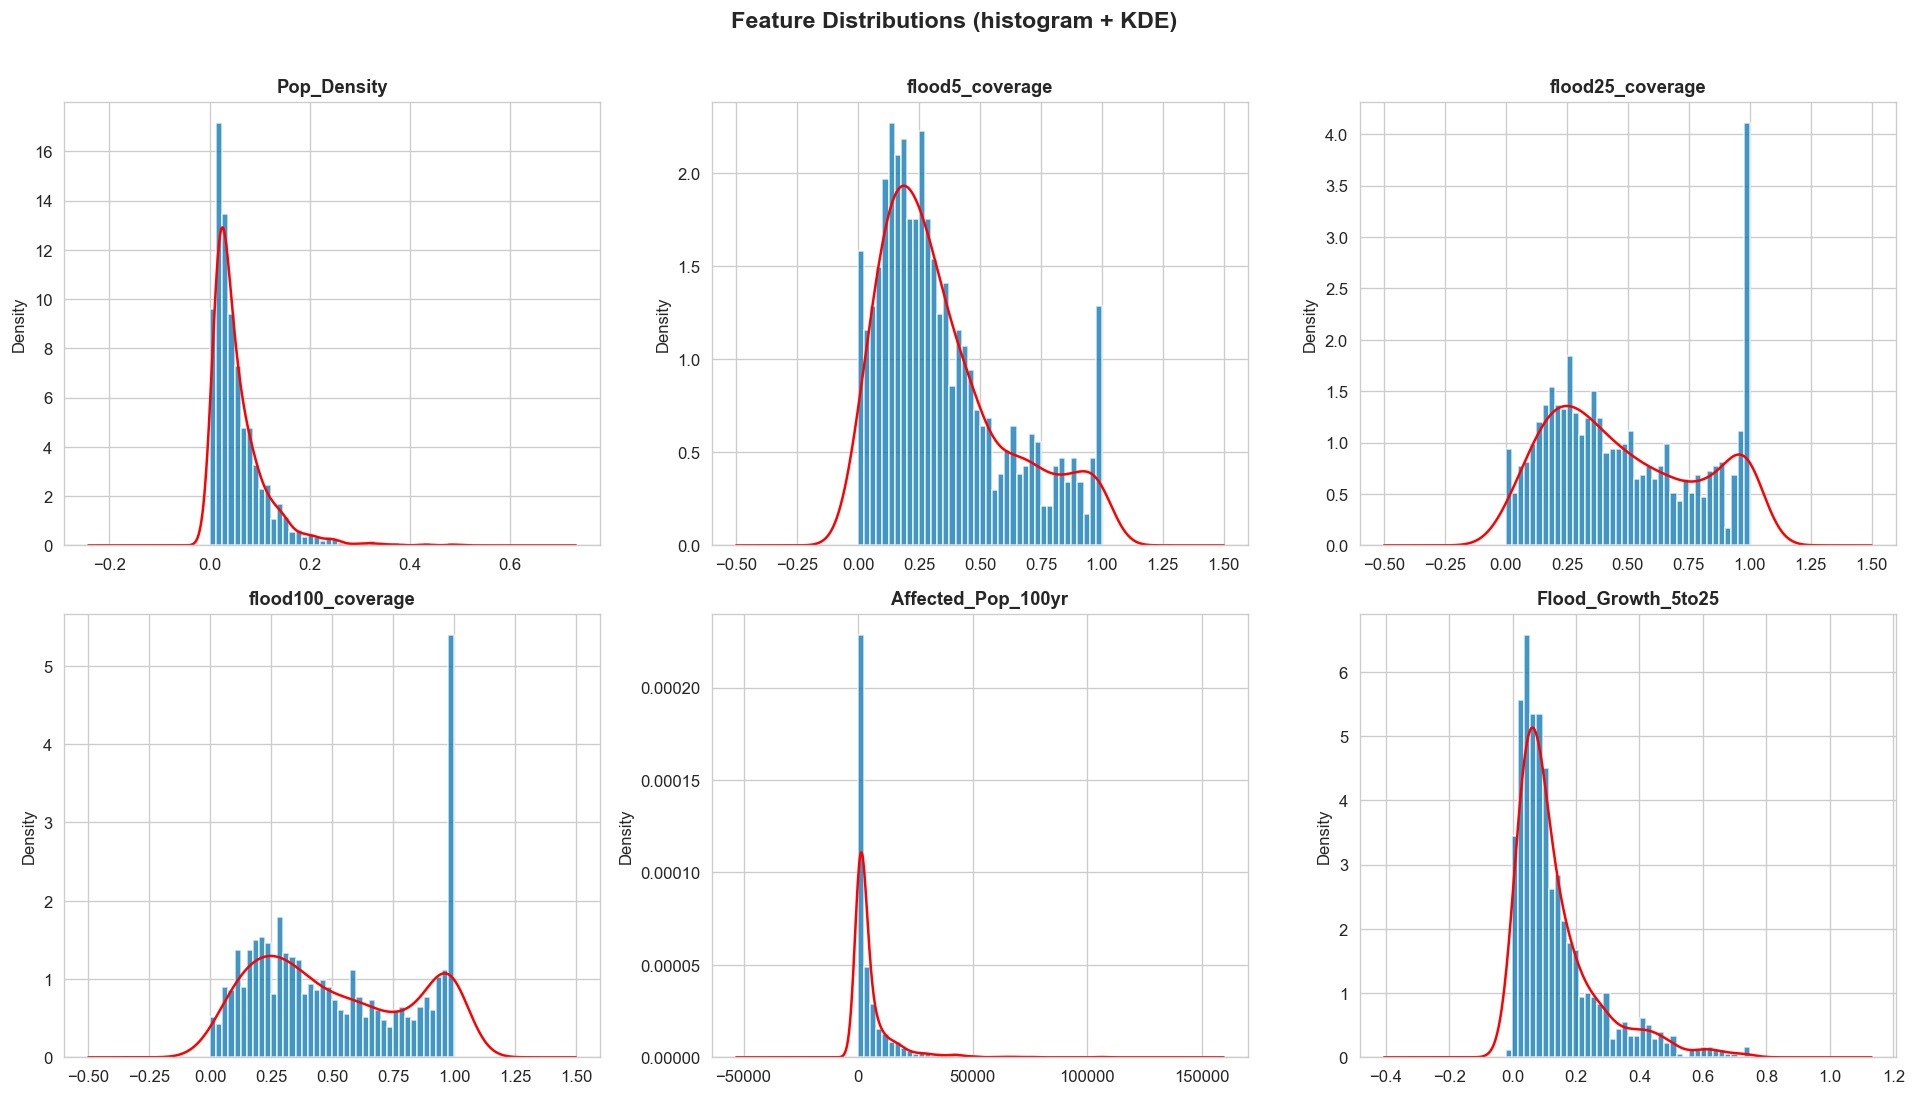

In [ ]:
# Histograms / KDE for key features 
plot_features = ['Pop_Density', 'flood5_coverage', 'flood25_coverage',
                 'flood100_coverage', 'Affected_Pop_100yr', 'Flood_Growth_5to25']

fig, axes = plt.subplots(2, 3, figsize=(16, 9))
for ax, col in zip(axes.flat, plot_features):
    vals = df[col].dropna()
    ax.hist(vals, bins=40, edgecolor='white', alpha=0.75, density=True)
    try:
        vals.plot.kde(ax=ax, color='red', linewidth=1.5)
    except Exception:
        pass
    ax.set_title(col, fontsize=11, fontweight='bold')
    ax.set_ylabel('Density')
fig.suptitle('Feature Distributions (histogram + KDE)', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
save_and_show('feature_distributions.png')

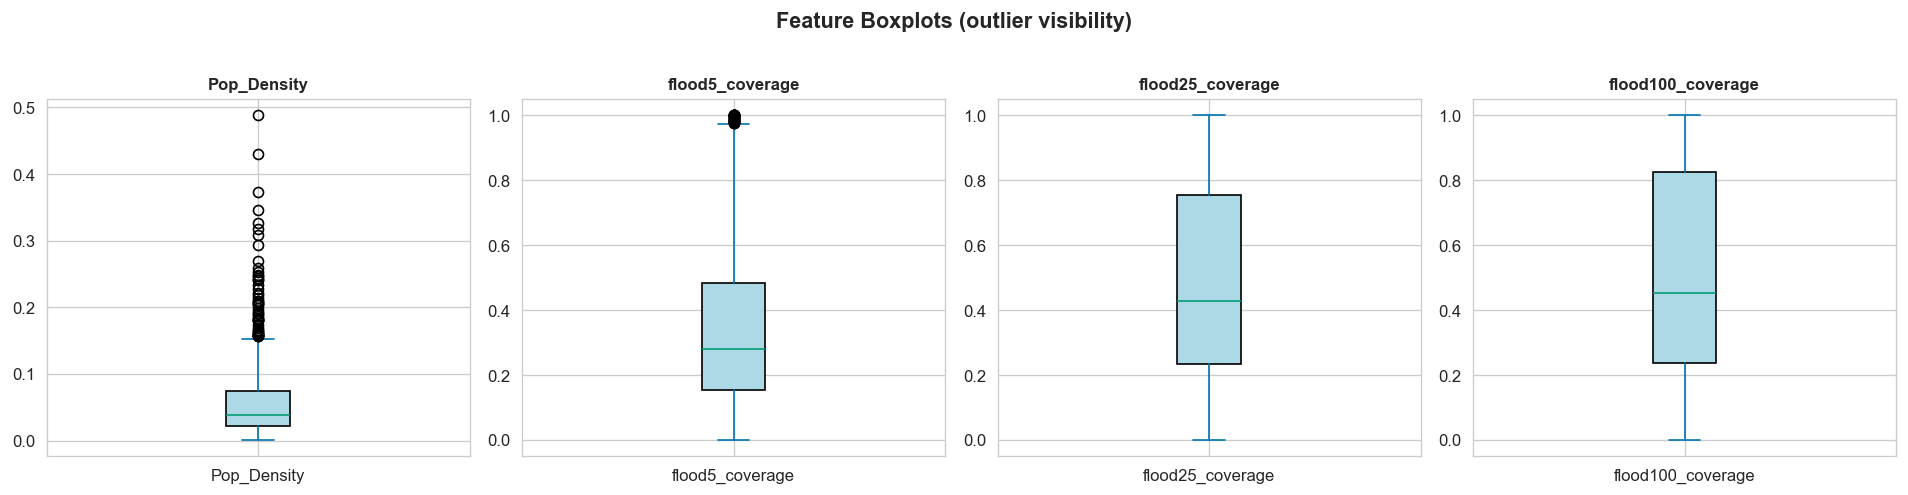

In [ ]:
# Boxplots for density and coverage 
box_cols = ['Pop_Density', 'flood5_coverage', 'flood25_coverage', 'flood100_coverage']
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for ax, col in zip(axes, box_cols):
    df[col].dropna().plot.box(ax=ax, vert=True, patch_artist=True,
                               boxprops=dict(facecolor='lightblue'))
    ax.set_title(col, fontsize=10, fontweight='bold')
plt.suptitle('Feature Boxplots (outlier visibility)', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
save_and_show('feature_boxplots.png')

## 5. Deterministic Benchmark: CSI + Vulnerability + DPI

#### Formulas
- **Vulnerability Score** (0–10): step-function on Pop_Density with thresholds calibrated
  to NCR census percentiles (0.02 / 0.04 / 0.07 ppl/m²)
- **Flood Score** (0–10): step-function on coverage ratio with PAGASA/NOAH-informed tiers
  (5% / 20% / 50% / 80%)
- **CSI** = 0.50 × Score_5yr + 0.30 × Score_25yr + 0.20 × Score_100yr
- **DPI** = 0.60 × CSI + 0.40 × Vulnerability
- **Risk classes**: Low (< 3.5) · Moderate (3.5–6.5) · High (≥ 6.5)

In [ ]:
# Vulnerability Score
df['Vulnerability_Score'] = df['Pop_Density'].apply(get_vuln_score)

# Flood Risk Scores
df['Assessment_5yr_Score']  = df['flood5_coverage'].apply(get_flood_score)
df['Assessment_25yr_Score'] = df['flood25_coverage'].apply(get_flood_score)
df['Assessment_100yr_Score']= df['flood100_coverage'].apply(get_flood_score)

# CSI
df['CSI'] = (df['Assessment_5yr_Score']  * 0.5 +
             df['Assessment_25yr_Score'] * 0.3 +
             df['Assessment_100yr_Score']* 0.2)

# DPI
df['DPI'] = df['CSI'] * 0.6 + df['Vulnerability_Score'] * 0.4

# Risk classes (proxy labels)
df['DPI_Risk_Class'] = df['DPI'].apply(dpi_to_risk_class)
df['DPI_Risk_Class_Proxy'] = df['DPI_Risk_Class']
df['ML_Risk_Class'] = df['DPI_Risk_Class']  # alias for backwards compatibility

print("DPI computation complete.")
print(f"DPI range: [{df['DPI'].min():.2f}, {df['DPI'].max():.2f}]")
print(f"DPI Risk Distribution:\n{df['DPI_Risk_Class'].value_counts().to_string()}")

DPI computation complete.
DPI range: [1.10, 10.00]
DPI Risk Distribution:
DPI_Risk_Class
Moderate    490
High        308
Low         137


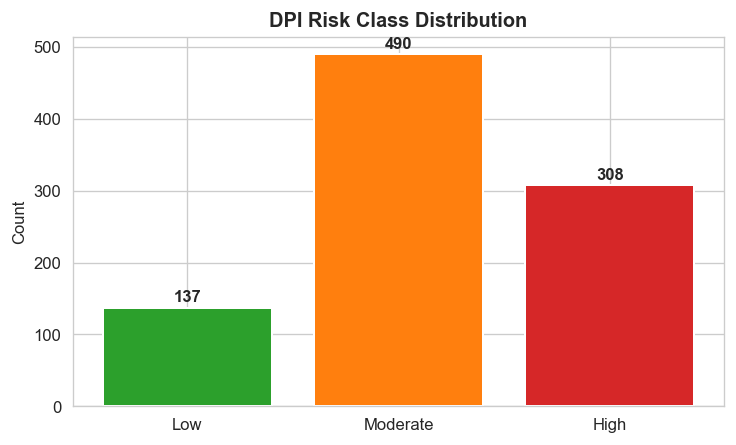

In [ ]:
# Bar chart: counts per risk class 
class_order = ['Low', 'Moderate', 'High']
class_colors = {'Low': '#2ca02c', 'Moderate': '#ff7f0e', 'High': '#d62728'}
counts = df['DPI_Risk_Class'].value_counts().reindex(class_order)

fig, ax = plt.subplots(figsize=(7, 4))
bars = ax.bar(counts.index, counts.values, color=[class_colors[c] for c in counts.index],
              edgecolor='white', linewidth=1.2)
for b in bars:
    ax.text(b.get_x() + b.get_width()/2, b.get_height() + 8,
            str(int(b.get_height())), ha='center', fontweight='bold')
ax.set_ylabel('Count')
ax.set_title('DPI Risk Class Distribution', fontweight='bold')
save_and_show('dpi_class_distribution.png')

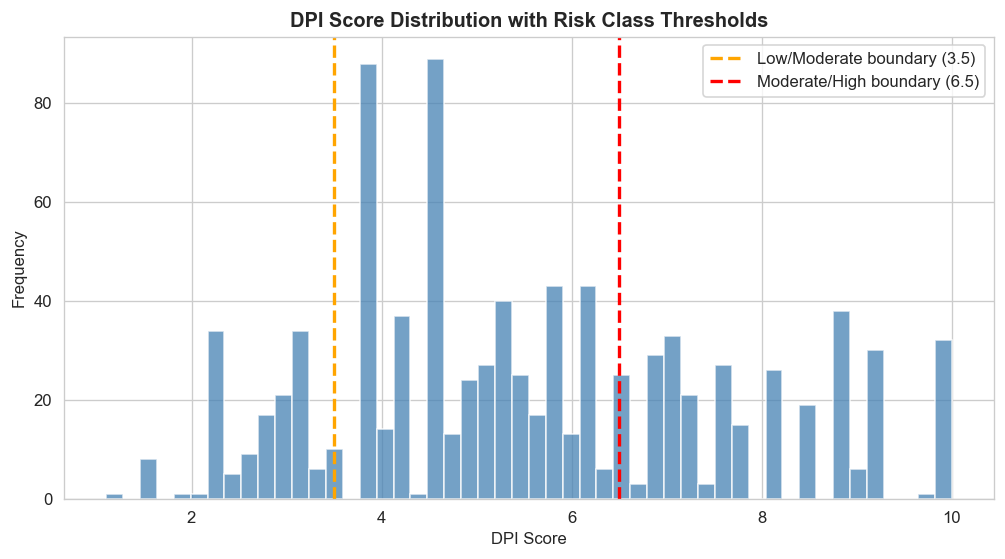

In [ ]:
# DPI histogram with threshold lines 
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(df['DPI'].dropna(), bins=50, edgecolor='white', alpha=0.75, color='steelblue')
ax.axvline(3.5, color='orange', linestyle='--', linewidth=2, label='Low/Moderate boundary (3.5)')
ax.axvline(6.5, color='red',    linestyle='--', linewidth=2, label='Moderate/High boundary (6.5)')
ax.legend(fontsize=10)
ax.set_xlabel('DPI Score')
ax.set_ylabel('Frequency')
ax.set_title('DPI Score Distribution with Risk Class Thresholds', fontweight='bold')
save_and_show('dpi_histogram_thresholds.png')

In [ ]:
# Top 10 & Bottom 10 by DPI
show_cols = ['Name', 'City', 'DPI', 'DPI_Risk_Class', 'flood100_coverage', 'Pop_Density', 'CSI']

print("Top 10 Barangays by DPI")
display(df.nlargest(10, 'DPI')[show_cols].reset_index(drop=True))

print("\nBottom 10 Barangays by DPI")
display(df.nsmallest(10, 'DPI')[show_cols].reset_index(drop=True))

Top 10 Barangays by DPI


,Name,City,DPI,DPI_Risk_Class,flood100_coverage,Pop_Density,CSI
0,Barangay 50,Manila,10.0,High,1.000000,0.119181,10.0
1,Barangay 52,Manila,10.0,High,0.996211,0.103523,10.0
2,Barangay 53,Manila,10.0,High,1.000000,0.118837,10.0
3,Barangay 58,Manila,10.0,High,1.000000,0.124523,10.0
4,Barangay 60,Manila,10.0,High,1.000000,0.138794,10.0
5,Barangay 63,Manila,10.0,High,1.000000,0.095373,10.0
6,Barangay 78,Manila,10.0,High,1.000000,0.082958,10.0
7,Barangay 98,Manila,10.0,High,0.976737,0.134831,10.0
8,Barangay 99,Manila,10.0,High,0.803170,0.487751,10.0
9,Barangay 138,Manila,10.0,High,0.996108,0.114383,10.0



Bottom 10 Barangays by DPI


,Name,City,DPI,DPI_Risk_Class,flood100_coverage,Pop_Density,CSI
0,Barangay 137,Caloocan,1.10,Low,0.072049,0.016360,0.50
1,Blue Ridge A,Quezon City,1.55,Low,0.063090,0.005448,1.25
2,Barangay 68,Caloocan,1.55,Low,0.058181,0.018117,1.25
3,Barangay 13,Caloocan,1.60,Low,0.013068,0.021364,0.00
4,Barangay 41,Caloocan,1.60,Low,0.018606,0.035288,0.00
5,Barangay 45,Caloocan,1.60,Low,0.036195,0.030627,0.00
6,Barangay 47,Caloocan,1.60,Low,0.040629,0.033723,0.00
7,Barangay 55,Caloocan,1.60,Low,0.041686,0.037173,0.00
8,Barangay 136,Caloocan,1.60,Low,0.042634,0.025729,0.00
9,Barangay 149,Caloocan,1.90,Low,0.132910,0.034287,0.50


## 6. Unsupervised Phase: K-Means Clustering + Risk Archetypes

K-Means is applied to **standardized engineered features** to discover natural
groupings ("Risk Archetypes") in the data. Clusters are **not** used as supervised
training labels — they serve as exploratory profiling to support policy interpretation.

**Steps**: silhouette-based K selection → clustering → semantic archetype mapping
→ diagnostics (silhouette, Davies–Bouldin, Calinski–Harabasz, ARI stability).

In [ ]:
# Feature collinearity check
print("Feature Collinearity Check (flood coverage ratios)")
_cov_cols = ['flood5_coverage', 'flood25_coverage', 'flood100_coverage']
for _i, _c1 in enumerate(_cov_cols):
    for _c2 in _cov_cols[_i+1:]:
        _v1 = pd.to_numeric(df[_c1], errors='coerce').values
        _v2 = pd.to_numeric(df[_c2], errors='coerce').values
        _valid = ~(np.isnan(_v1) | np.isnan(_v2))
        if _valid.sum() > 2:
            _rho, _pval = spearmanr(_v1[_valid], _v2[_valid])
            print(f"  {_c1} vs {_c2}: Spearman rho={_rho:.4f} (p={_pval:.2e})")
print("  flood25_coverage excluded from model features due to high collinearity.")

# Coerce features to numeric; NaNs preserved for Pipeline imputer
for col in FEATURE_COLS:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Feature matrix 
X = df[FEATURE_COLS].to_numpy()

# Pre-scaled matrix for KMeans only (no train/test leakage concern)
_imputer = SimpleImputer(strategy='mean')
_scaler  = StandardScaler()
X_scaled = _scaler.fit_transform(_imputer.fit_transform(X))

print(f"\nFeature matrix: {X.shape}")

Feature Collinearity Check (flood coverage ratios)
  flood5_coverage vs flood25_coverage: Spearman rho=0.9237 (p=0.00e+00)
  flood5_coverage vs flood100_coverage: Spearman rho=0.8529 (p=1.44e-265)
  flood25_coverage vs flood100_coverage: Spearman rho=0.9463 (p=0.00e+00)
  flood25_coverage excluded from model features due to high collinearity.

Feature matrix: (935, 6)


Selected K=6 (silhouette=0.3835)


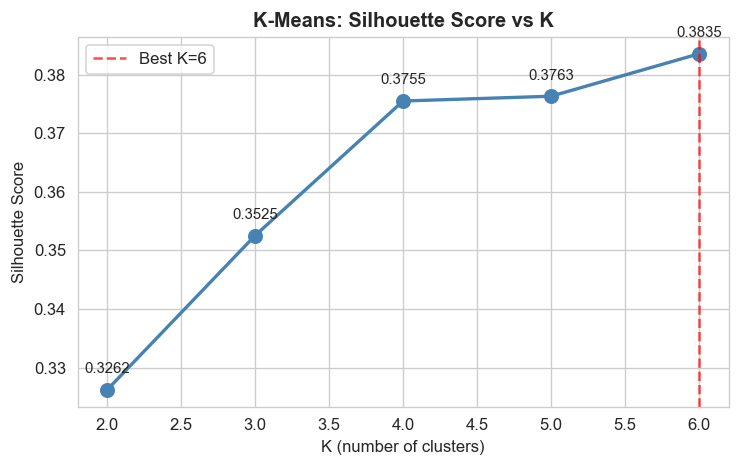

In [ ]:
# K selection via silhouette
k_range = range(2, 7)
k_silhouettes = {}
for k in k_range:
    km_temp = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels_temp = km_temp.fit_predict(X_scaled)
    k_silhouettes[k] = silhouette_score(X_scaled, labels_temp)

best_k = max(k_silhouettes, key=k_silhouettes.get)
print(f"Selected K={best_k} (silhouette={k_silhouettes[best_k]:.4f})")

# Line chart: silhouette vs K
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(list(k_silhouettes.keys()), list(k_silhouettes.values()),
        'o-', linewidth=2, markersize=8, color='steelblue')
ax.axvline(best_k, color='red', linestyle='--', alpha=0.7, label=f'Best K={best_k}')
for k, s in k_silhouettes.items():
    ax.annotate(f'{s:.4f}', (k, s), textcoords='offset points',
                xytext=(0, 10), ha='center', fontsize=9)
ax.set_xlabel('K (number of clusters)')
ax.set_ylabel('Silhouette Score')
ax.set_title('K-Means: Silhouette Score vs K', fontweight='bold')
ax.legend()
save_and_show('silhouette_vs_k.png')

Clustering Diagnostics (K=6)


,Metric,Value,Interpretation
0,Silhouette Score,0.3835,Higher = better
1,Davies-Bouldin Index,0.9881,Lower = better
2,Calinski-Harabasz Index,368.90,Higher = better



Stability (ARI vs seed=42, 10 seeds)


,Statistic,Value
0,Mean ARI,0.9856
1,Min ARI,0.9799
2,Max ARI,0.9883
3,Std ARI,0.0028


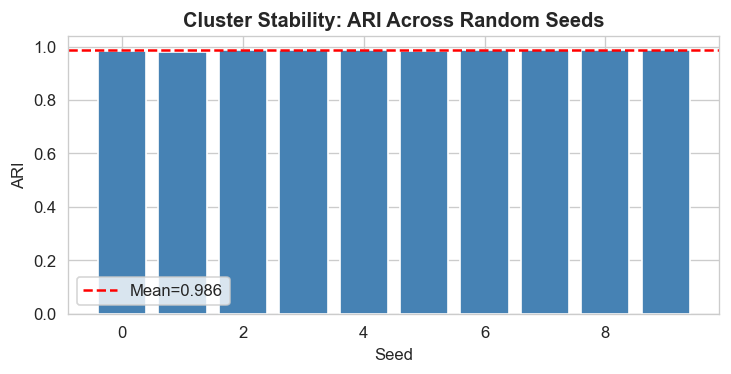

In [ ]:
# Final clustering 
kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
df['Cluster_Group'] = clusters

# Clustering diagnostics
sil = silhouette_score(X_scaled, clusters)
db  = davies_bouldin_score(X_scaled, clusters)
ch  = calinski_harabasz_score(X_scaled, clusters)

diag_df = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index'],
    'Value': [f'{sil:.4f}', f'{db:.4f}', f'{ch:.2f}'],
    'Interpretation': ['Higher = better', 'Lower = better', 'Higher = better'],
})
print("Clustering Diagnostics (K={})".format(best_k))
display(diag_df)

# ARI stability across seeds
baseline_labels = clusters
ari_scores = []
for seed in range(10):
    km_alt = KMeans(n_clusters=best_k, random_state=seed, n_init=10)
    alt_labels = km_alt.fit_predict(X_scaled)
    ari_scores.append(adjusted_rand_score(baseline_labels, alt_labels))

ari_df = pd.DataFrame({
    'Statistic': ['Mean ARI', 'Min ARI', 'Max ARI', 'Std ARI'],
    'Value': [f'{np.mean(ari_scores):.4f}', f'{np.min(ari_scores):.4f}',
              f'{np.max(ari_scores):.4f}', f'{np.std(ari_scores):.4f}'],
})
print(f"\nStability (ARI vs seed=42, 10 seeds)")
display(ari_df)

# ARI bar plot
fig, ax = plt.subplots(figsize=(7, 3))
ax.bar(range(10), ari_scores, color='steelblue', edgecolor='white')
ax.axhline(np.mean(ari_scores), color='red', linestyle='--', label=f'Mean={np.mean(ari_scores):.3f}')
ax.set_xlabel('Seed')
ax.set_ylabel('ARI')
ax.set_title('Cluster Stability: ARI Across Random Seeds', fontweight='bold')
ax.legend()
save_and_show('ari_stability.png')

In [ ]:
# Semantic archetype mapping
cluster_means = df.groupby('Cluster_Group')[['Pop_Density', 'flood100_coverage']].mean(numeric_only=True)
density_median  = cluster_means['Pop_Density'].median()
exposure_median = cluster_means['flood100_coverage'].median()

archetype_map = {}
for group, row in cluster_means.iterrows():
    d_tag = 'HighDensity'  if row['Pop_Density']       >= density_median  else 'LowDensity'
    e_tag = 'HighExposure' if row['flood100_coverage']  >= exposure_median else 'LowExposure'
    archetype_map[group] = f'{d_tag}-{e_tag}'

df['Risk_Archetype'] = df['Cluster_Group'].map(archetype_map)

# Report mapping 
print(f"Cluster-to-Archetype Mapping (K={best_k} clusters -> 4 semantic archetypes):")
mapping_rows = []
for cid in sorted(archetype_map.keys()):
    n = (df['Cluster_Group'] == cid).sum()
    mapping_rows.append({'Cluster': cid, 'Archetype': archetype_map[cid], 'n': n})
    print(f"  Cluster {cid} -> {archetype_map[cid]}  (n={n})")
print(f"Archetype summary: {dict(Counter(archetype_map.values()))}")

Cluster-to-Archetype Mapping (K=6 clusters -> 4 semantic archetypes):
  Cluster 0 -> LowDensity-HighExposure  (n=28)
  Cluster 1 -> LowDensity-LowExposure  (n=440)
  Cluster 2 -> HighDensity-LowExposure  (n=65)
  Cluster 3 -> LowDensity-LowExposure  (n=91)
  Cluster 4 -> HighDensity-HighExposure  (n=134)
  Cluster 5 -> HighDensity-HighExposure  (n=177)
Archetype summary: {'LowDensity-HighExposure': 1, 'LowDensity-LowExposure': 2, 'HighDensity-LowExposure': 1, 'HighDensity-HighExposure': 2}


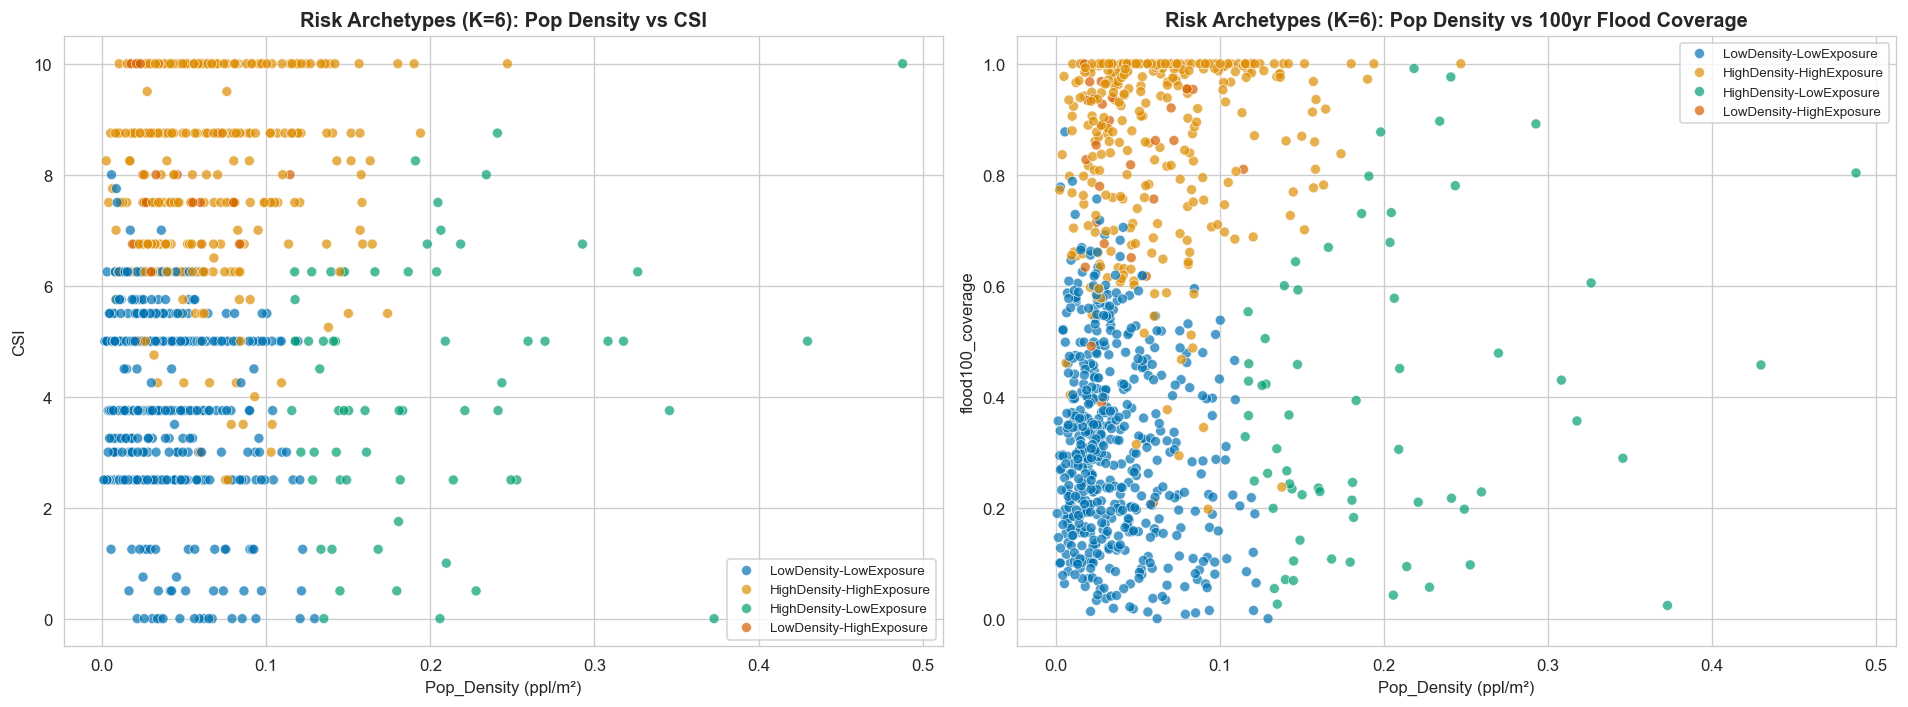

In [ ]:
# Scatter: Pop_Density vs CSI (colored by archetype) 
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(data=df, x='Pop_Density', y='CSI', hue='Risk_Archetype',
                alpha=0.7, ax=axes[0])
axes[0].set_xlabel('Pop_Density (ppl/m²)')
axes[0].set_ylabel('CSI')
axes[0].set_title(f'Risk Archetypes (K={best_k}): Pop Density vs CSI', fontweight='bold')
axes[0].legend(fontsize=8, loc='best')

# Scatter: Pop_Density vs flood100_coverage (matches archetype label logic) 
sns.scatterplot(data=df, x='Pop_Density', y='flood100_coverage', hue='Risk_Archetype',
                alpha=0.7, ax=axes[1])
axes[1].set_xlabel('Pop_Density (ppl/m²)')
axes[1].set_ylabel('flood100_coverage')
axes[1].set_title(f'Risk Archetypes (K={best_k}): Pop Density vs 100yr Flood Coverage', fontweight='bold')
axes[1].legend(fontsize=8, loc='best')

plt.tight_layout()
save_and_show('kmeans_cluster_chart.png')

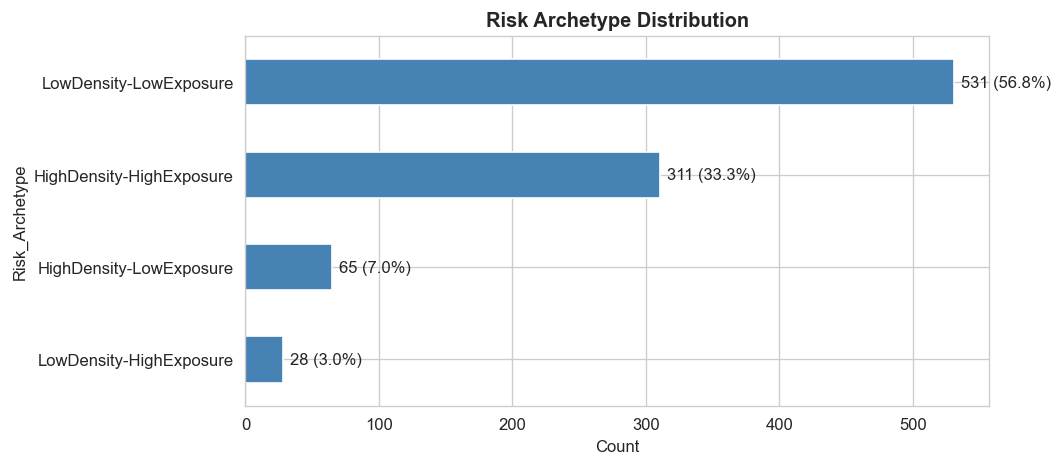

In [ ]:
# Bar chart: counts per archetype 
arch_counts = df['Risk_Archetype'].value_counts()

fig, ax = plt.subplots(figsize=(8, 4))
arch_counts.plot.barh(ax=ax, color='steelblue', edgecolor='white')
for i, (val, name) in enumerate(zip(arch_counts.values, arch_counts.index)):
    ax.text(val + 5, i, f'{val} ({val/len(df):.1%})', va='center', fontsize=10)
ax.set_xlabel('Count')
ax.set_title('Risk Archetype Distribution', fontweight='bold')
ax.invert_yaxis()
save_and_show('archetype_distribution.png')

## 7. Supervised Phase: Classification (DPI Risk Class)

Models predict the **DPI-derived risk class** (Low / Moderate / High) — a proxy
label constructed from our own index, **not** an external ground truth. High accuracy
is expected by construction and should be interpreted as measuring how well each
learner approximates the deterministic benchmark.

**Baselines**: Dummy (majority), Logistic Regression, Shallow Decision Tree, Ordinal Ridge\
**Primary**: Random Forest, Gradient Boosting, Neural Network (MLP)\
**Evaluation**: 80/20 stratified split → 5-fold StratifiedKFold → GroupKFold by City

In [ ]:
# Targets
y_class = df['DPI_Risk_Class'].map(ORDINAL_MAP).astype(int).to_numpy()
y_reg   = df['DPI'].astype(float).to_numpy()

# 80/20 stratified split
X_train, X_test, yc_train, yc_test, yr_train, yr_test = train_test_split(
    X, y_class, y_reg, test_size=0.2, random_state=RANDOM_STATE, stratify=y_class)

print(f"Train: {X_train.shape[0]}  Test: {X_test.shape[0]}")
print(f"Class distribution (test): { {INVERSE_ORDINAL_MAP[c]: int(n) for c, n in zip(*np.unique(yc_test, return_counts=True))} }")

# Instantiate models
baseline_clf = get_baseline_clf_models()
primary_clf  = get_primary_clf_models()

# Train & evaluate on holdout
def eval_clf(models, X_tr, y_tr, X_te, y_te, ordinal_name=MODEL_NAMES['ord_ridge']):
    results = {}
    for name, model in models.items():
        model.fit(X_tr, y_tr)
        if name == ordinal_name:
            y_pred = np.clip(np.round(model.predict(X_te)).astype(int), 0, 2)
        else:
            y_pred = model.predict(X_te)
        results[name] = {
            'acc':      accuracy_score(y_te, y_pred),
            'bal_acc':  balanced_accuracy_score(y_te, y_pred),
            'f1w':      f1_score(y_te, y_pred, average='weighted', zero_division=0),
            'f1_macro': f1_score(y_te, y_pred, average='macro', zero_division=0),
            'cm':       confusion_matrix(y_te, y_pred, labels=[0, 1, 2]),
            'y_pred':   y_pred,
            'model':    model,
        }
    return results

baseline_clf_res = eval_clf(baseline_clf, X_train, yc_train, X_test, yc_test)
primary_clf_res  = eval_clf(primary_clf,  X_train, yc_train, X_test, yc_test)

# Merge for unified access
all_clf_res = {**baseline_clf_res, **primary_clf_res}

print("\nHoldout Classification Results")
for name, r in all_clf_res.items():
    tag = '(B)' if name in BASELINE_CLF_NAMES else '(P)'
    print(f"  {tag} [{name}] Acc={r['acc']:.2%} BalAcc={r['bal_acc']:.2%} "
          f"F1w={r['f1w']:.2%} F1macro={r['f1_macro']:.2%}")

Train: 748  Test: 187
Class distribution (test): {'Low': 27, 'Moderate': 98, 'High': 62}

Holdout Classification Results
  (B) [Dummy (Majority Class)] Acc=52.41% BalAcc=33.33% F1w=36.04% F1macro=22.92%
  (B) [Logistic Regression] Acc=85.56% BalAcc=85.46% F1w=85.68% F1macro=86.77%
  (B) [Shallow Decision Tree] Acc=71.12% BalAcc=71.92% F1w=71.76% F1macro=69.29%
  (B) [Ordinal Ridge (rounded)] Acc=82.35% BalAcc=76.76% F1w=82.07% F1macro=80.24%
  (P) [Random Forest] Acc=95.19% BalAcc=94.56% F1w=95.19% F1macro=94.65%
  (P) [Gradient Boosting] Acc=95.72% BalAcc=95.10% F1w=95.72% F1macro=95.42%
  (P) [Neural Network (MLP)] Acc=93.58% BalAcc=92.25% F1w=93.58% F1macro=92.93%


### 7.1 Baseline vs. Primary Comparison — Classification

All models below are evaluated on the **same holdout split** and **same CV folds**.

| Category | Models | Purpose |
|----------|--------|---------|
| **Baseline** (B) | Dummy (majority class), Logistic Regression, Shallow Decision Tree (depth=2), Ordinal Ridge | Establish performance floor; any primary model must beat these to justify complexity |
| **Primary** (P) | Random Forest, Gradient Boosting, MLP Neural Network | Test whether non-linear learners meaningfully improve on the deterministic benchmark |

> **Reading the results**: In tables, `(B)` = Baseline, `(P)` = Primary. In bar charts, **orange = Baseline**, **blue = Primary**.

In [ ]:
# Cross-validation: 5-Fold Stratified + GroupKFold by City
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
groups = df['City'].values
n_groups = df['City'].nunique()
gkf = GroupKFold(n_splits=min(5, n_groups))

all_clf_cv_models = {}
all_clf_cv_models.update({f"(B) {n}": m for n, m in baseline_clf.items()})
all_clf_cv_models.update({f"(P) {n}": m for n, m in primary_clf.items()})

cv_clf_records = []

for name, mdl in all_clf_cv_models.items():
    is_ord = 'Ordinal Ridge' in name
    # Standard CV
    m1 = clone(mdl)
    sw = cross_val_score(m1, X, y_class, cv=skf,
                         scoring=_ordinal_ridge_f1w if is_ord else 'f1_weighted')
    m2 = clone(mdl)
    sm = cross_val_score(m2, X, y_class, cv=skf,
                         scoring=_ordinal_ridge_f1m if is_ord else 'f1_macro')
    # Spatial CV
    m3 = clone(mdl)
    gw = cross_val_score(m3, X, y_class, cv=gkf, groups=groups,
                         scoring=_ordinal_ridge_f1w if is_ord else 'f1_weighted')
    m4 = clone(mdl)
    gm = cross_val_score(m4, X, y_class, cv=gkf, groups=groups,
                         scoring=_ordinal_ridge_f1m if is_ord else 'f1_macro')

    # Look up holdout results
    base_name = name[4:]  # strip "(B) " or "(P) "
    ho = all_clf_res.get(base_name, {})
    tag = name[:3]

    cv_clf_records.append({
        'Model': base_name, 'Type': 'Baseline' if tag == '(B)' else 'Primary',
        'HO Acc':     ho.get('acc', np.nan),
        'HO BalAcc':  ho.get('bal_acc', np.nan),
        'HO F1w':     ho.get('f1w', np.nan),
        'HO F1macro': ho.get('f1_macro', np.nan),
        'CV F1w':         f'{sw.mean():.4f}+/-{sw.std():.4f}',
        'CV F1macro':     f'{sm.mean():.4f}+/-{sm.std():.4f}',
        'Spatial F1w':    f'{gw.mean():.4f}+/-{gw.std():.4f}',
        'Spatial F1macro':f'{gm.mean():.4f}+/-{gm.std():.4f}',
        '_cv_f1w_mean': sw.mean(), '_cv_f1w_std': sw.std(),
        '_sp_f1w_mean': gw.mean(), '_sp_f1w_std': gw.std(),
    })

cv_clf_df = pd.DataFrame(cv_clf_records)

# Defense-ready benchmark table (Guide §B: 2-4 algorithms, highlight best) 
_bench_models = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'Neural Network (MLP)']
_bench_clf = (
    cv_clf_df[cv_clf_df['Model'].isin(_bench_models)]
    [['Model', 'HO Acc', 'HO BalAcc', 'HO F1w', 'HO F1macro']]
    .copy()
    .rename(columns={
        'HO Acc': 'Accuracy', 'HO BalAcc': 'Bal. Accuracy',
        'HO F1w': 'Weighted F1', 'HO F1macro': 'Macro F1',
    })
    .reset_index(drop=True)
)

def _hl_max(s):
    is_best = s == s.max()
    return ['background-color: #d4edda; font-weight: bold' if v else '' for v in is_best]

print("Classification Benchmark (Holdout Set)")
display(
    _bench_clf.style
    .apply(_hl_max, subset=['Accuracy', 'Bal. Accuracy', 'Weighted F1', 'Macro F1'])
    .format('{:.2%}', subset=['Accuracy', 'Bal. Accuracy', 'Weighted F1', 'Macro F1'])
    .set_caption('Classification — Best Values Highlighted')
    .hide(axis='index')
)

# Full table retained for reference
print("\nFull Classification: Holdout + CV + Spatial CV")
display(cv_clf_df[['Model','Type','HO F1w','HO F1macro','CV F1w','CV F1macro','Spatial F1w','Spatial F1macro']])

Classification Benchmark (Holdout Set)


Model,Accuracy,Bal. Accuracy,Weighted F1,Macro F1
Logistic Regression,85.56%,85.46%,85.68%,86.77%
Random Forest,95.19%,94.56%,95.19%,94.65%
Gradient Boosting,95.72%,95.10%,95.72%,95.42%
Neural Network (MLP),93.58%,92.25%,93.58%,92.93%



Full Classification: Holdout + CV + Spatial CV


,Model,Type,HO F1w,HO F1macro,CV F1w,CV F1macro,Spatial F1w,Spatial F1macro
0,Dummy (Majority Class),Baseline,0.360409,0.229240,0.3604+/-0.0000,0.2292+/-0.0000,0.3860+/-0.1821,0.2267+/-0.0481
1,Logistic Regression,Baseline,0.856773,0.867748,0.8639+/-0.0365,0.8616+/-0.0422,0.8457+/-0.0185,0.8052+/-0.0464
2,Shallow Decision Tree,Baseline,0.717592,0.692876,0.6746+/-0.0451,0.6009+/-0.0963,0.6276+/-0.1287,0.5158+/-0.1089
3,Ordinal Ridge (rounded),Baseline,0.820694,0.802449,0.8037+/-0.0292,0.7672+/-0.0400,0.7819+/-0.0665,0.7244+/-0.0686
4,Random Forest,Primary,0.951885,0.946530,0.9400+/-0.0514,0.9377+/-0.0560,0.9348+/-0.0205,0.9105+/-0.0193
5,Gradient Boosting,Primary,0.957175,0.954193,0.9646+/-0.0232,0.9637+/-0.0271,0.9481+/-0.0161,0.9413+/-0.0267
6,Neural Network (MLP),Primary,0.935754,0.929270,0.9242+/-0.0325,0.9159+/-0.0368,0.9155+/-0.0078,0.8784+/-0.0404


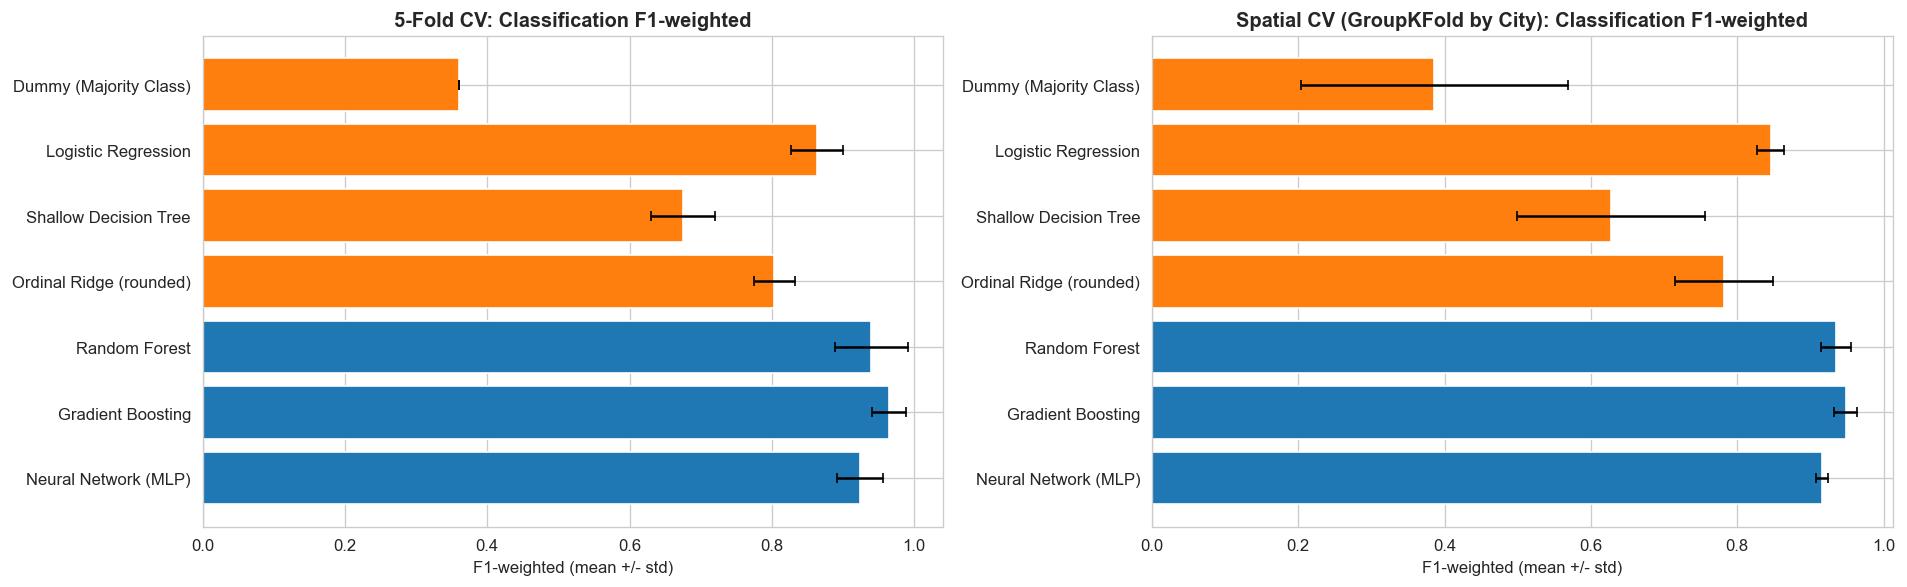

In [ ]:
# Classification bar charts
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# CV F1-weighted
ax = axes[0]
colors = ['#ff7f0e' if t == 'Baseline' else '#1f77b4' for t in cv_clf_df['Type']]
ax.barh(cv_clf_df['Model'], cv_clf_df['_cv_f1w_mean'], xerr=cv_clf_df['_cv_f1w_std'],
        color=colors, edgecolor='white', capsize=3)
ax.set_xlabel('F1-weighted (mean +/- std)')
ax.set_title('5-Fold CV: Classification F1-weighted', fontweight='bold')
ax.invert_yaxis()

# Spatial CV F1-weighted
ax = axes[1]
ax.barh(cv_clf_df['Model'], cv_clf_df['_sp_f1w_mean'], xerr=cv_clf_df['_sp_f1w_std'],
        color=colors, edgecolor='white', capsize=3)
ax.set_xlabel('F1-weighted (mean +/- std)')
ax.set_title('Spatial CV (GroupKFold by City): Classification F1-weighted', fontweight='bold')
ax.invert_yaxis()

plt.tight_layout()
save_and_show('clf_cv_comparison.png')

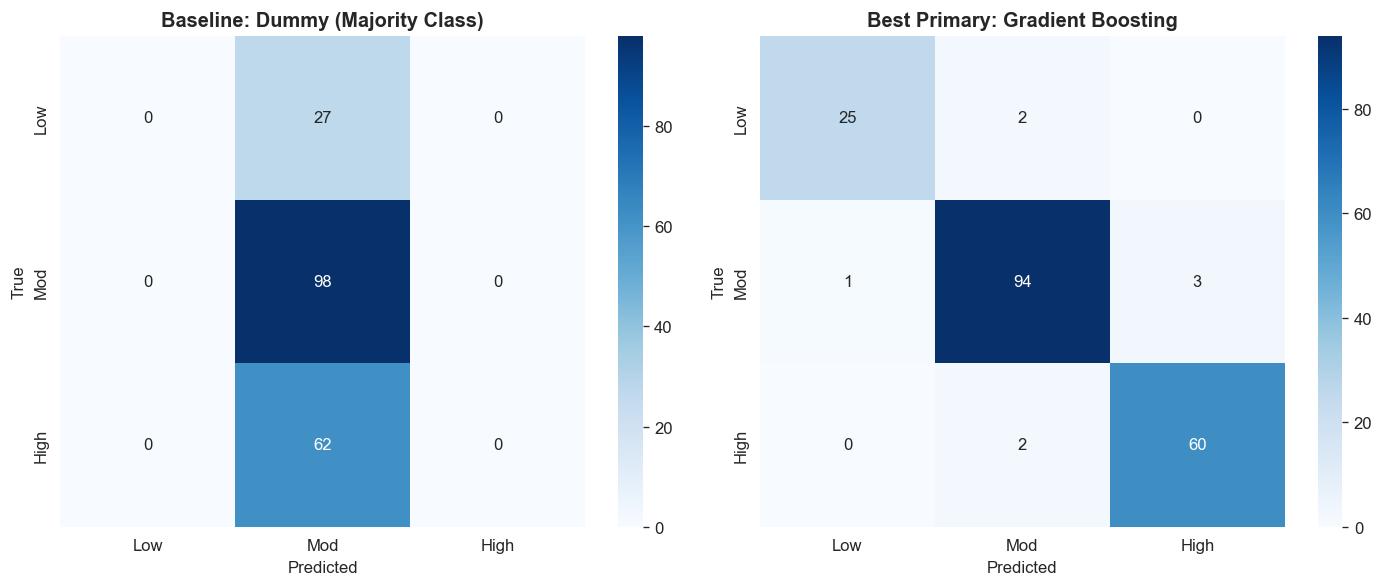

In [ ]:
# Confusion matrices: Dummy vs Best model
best_clf_name = max(primary_clf_res, key=lambda n: primary_clf_res[n]['f1w'])
dummy_name    = MODEL_NAMES['dummy_clf']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, (name, title) in zip(axes, [(dummy_name, f'Baseline: {dummy_name}'),
                                     (best_clf_name, f'Best Primary: {best_clf_name}')]):
    cm = all_clf_res[name]['cm']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Low','Mod','High'], yticklabels=['Low','Mod','High'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title, fontweight='bold')

plt.tight_layout()
save_and_show('confusion_matrices.png')

## 8. Supervised Phase: Regression (DPI Score)

Models predict the **continuous DPI score** (0–10). Same baseline-vs-primary comparison
with identical evaluation protocols.

In [ ]:
# Train & evaluate regression
baseline_reg = get_baseline_reg_models()
primary_reg  = get_primary_reg_models()

def eval_reg(models, X_tr, y_tr, X_te, y_te):
    results = {}
    for name, model in models.items():
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)
        results[name] = {
            'rmse': float(np.sqrt(mean_squared_error(y_te, y_pred))),
            'mae':  float(mean_absolute_error(y_te, y_pred)),
            'y_pred': y_pred,
            'model': model,
        }
    return results

baseline_reg_res = eval_reg(baseline_reg, X_train, yr_train, X_test, yr_test)
primary_reg_res  = eval_reg(primary_reg,  X_train, yr_train, X_test, yr_test)
all_reg_res = {**baseline_reg_res, **primary_reg_res}

# CV + Spatial CV 
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

all_reg_cv_models = {}
all_reg_cv_models.update({f"(B) {n}": m for n, m in baseline_reg.items()})
all_reg_cv_models.update({f"(P) {n}": m for n, m in primary_reg.items()})

cv_reg_records = []
cv_reg_results_dict = {}  # for PDF report

for name, mdl in all_reg_cv_models.items():
    m1 = clone(mdl)
    s_rmse = cross_val_score(m1, X, y_reg, cv=kf, scoring='neg_root_mean_squared_error')
    m2 = clone(mdl)
    s_mae  = cross_val_score(m2, X, y_reg, cv=kf, scoring='neg_mean_absolute_error')
    m3 = clone(mdl)
    g_rmse = cross_val_score(m3, X, y_reg, cv=gkf, groups=groups, scoring='neg_root_mean_squared_error')
    m4 = clone(mdl)
    g_mae  = cross_val_score(m4, X, y_reg, cv=gkf, groups=groups, scoring='neg_mean_absolute_error')

    cv_reg_results_dict[name] = {'rmse': s_rmse, 'mae': s_mae}

    base_name = name[4:]
    ho = all_reg_res.get(base_name, {})
    tag = name[:3]
    cv_reg_records.append({
        'Model': base_name, 'Type': 'Baseline' if tag == '(B)' else 'Primary',
        'HO RMSE': ho.get('rmse', np.nan),
        'HO MAE':  ho.get('mae', np.nan),
        'CV RMSE':      f'{-s_rmse.mean():.4f}+/-{s_rmse.std():.4f}',
        'CV MAE':       f'{-s_mae.mean():.4f}+/-{s_mae.std():.4f}',
        'Spatial RMSE': f'{-g_rmse.mean():.4f}+/-{g_rmse.std():.4f}',
        'Spatial MAE':  f'{-g_mae.mean():.4f}+/-{g_mae.std():.4f}',
        '_cv_rmse_mean': -s_rmse.mean(), '_cv_rmse_std': s_rmse.std(),
        '_sp_rmse_mean': -g_rmse.mean(), '_sp_rmse_std': g_rmse.std(),
    })

cv_reg_df = pd.DataFrame(cv_reg_records)

# Defense-ready benchmark table (Guide §B: 2-4 algorithms, highlight best) 
_bench_reg_models = ['Ridge Regression', 'Random Forest', 'Gradient Boosting', 'Neural Network (MLP)']
_bench_reg = (
    cv_reg_df[cv_reg_df['Model'].isin(_bench_reg_models)]
    [['Model', 'HO RMSE', 'HO MAE']]
    .copy()
    .rename(columns={'HO RMSE': 'RMSE', 'HO MAE': 'MAE'})
    .reset_index(drop=True)
)

def _hl_min(s):
    is_best = s == s.min()
    return ['background-color: #d4edda; font-weight: bold' if v else '' for v in is_best]

print("Regression Benchmark (Holdout Set)")
display(
    _bench_reg.style
    .apply(_hl_min, subset=['RMSE', 'MAE'])
    .format('{:.4f}', subset=['RMSE', 'MAE'])
    .set_caption('Regression — Best Values Highlighted')
    .hide(axis='index')
)

# Full table retained for reference
print("\nFull Regression: Holdout + CV + Spatial CV")
_reg_display = cv_reg_df[['Model','Type','HO RMSE','HO MAE','CV RMSE','CV MAE','Spatial RMSE','Spatial MAE']].copy()
_ho_reg_cols = ['HO RMSE', 'HO MAE']

def _highlight_min_col(s):
    is_best = s == s.min()
    return ['background-color: #d4edda; font-weight: bold' if v else '' for v in is_best]

def _highlight_cv_min(s):
    means = s.apply(lambda x: float(str(x).split('+/-')[0]) if '+/-' in str(x) else float('nan'))
    is_best = means == means.min()
    return ['background-color: #d4edda; font-weight: bold' if v else '' for v in is_best]

_styled_reg = (
    _reg_display.style
    .apply(_highlight_min_col, subset=_ho_reg_cols)
    .apply(_highlight_cv_min, subset=['CV RMSE', 'CV MAE', 'Spatial RMSE', 'Spatial MAE'])
    .format(precision=4, subset=_ho_reg_cols)
    .set_caption('Regression Full Results — Best Values Highlighted')
)
display(_styled_reg)

Regression Benchmark (Holdout Set)


Model,RMSE,MAE
Ridge Regression,0.7885,0.6561
Random Forest,0.2274,0.1459
Gradient Boosting,0.1911,0.1278
Neural Network (MLP),0.4094,0.3293



Full Regression: Holdout + CV + Spatial CV


,Model,Type,HO RMSE,HO MAE,CV RMSE,CV MAE,Spatial RMSE,Spatial MAE
0,Dummy (Mean Predictor),Baseline,2.0422,1.6543,2.0567+/-0.0712,1.7017+/-0.0541,2.1811+/-0.4079,1.8396+/-0.3863
1,Ridge Regression,Baseline,0.7885,0.6561,0.7792+/-0.0369,0.6199+/-0.0192,0.8016+/-0.1157,0.6417+/-0.0729
2,Random Forest,Primary,0.2274,0.1459,0.2246+/-0.0113,0.1398+/-0.0091,0.2892+/-0.0573,0.1787+/-0.0313
3,Gradient Boosting,Primary,0.1911,0.1278,0.1914+/-0.0106,0.1308+/-0.0067,0.2296+/-0.0262,0.1558+/-0.0185
4,Neural Network (MLP),Primary,0.4094,0.3293,0.4146+/-0.0203,0.3333+/-0.0149,0.4525+/-0.0568,0.3609+/-0.0379


### 8.1 Baseline vs. Primary Comparison — Regression

| Category | Models | Purpose |
|----------|--------|---------|
| **Baseline** (B) | Dummy (mean predictor), Ridge Regression | Establish performance floor for continuous DPI prediction |
| **Primary** (P) | Random Forest, Gradient Boosting, MLP Neural Network | Test non-linear learners on continuous DPI score |

> Same color convention: **orange = Baseline**, **blue = Primary** in bar charts.

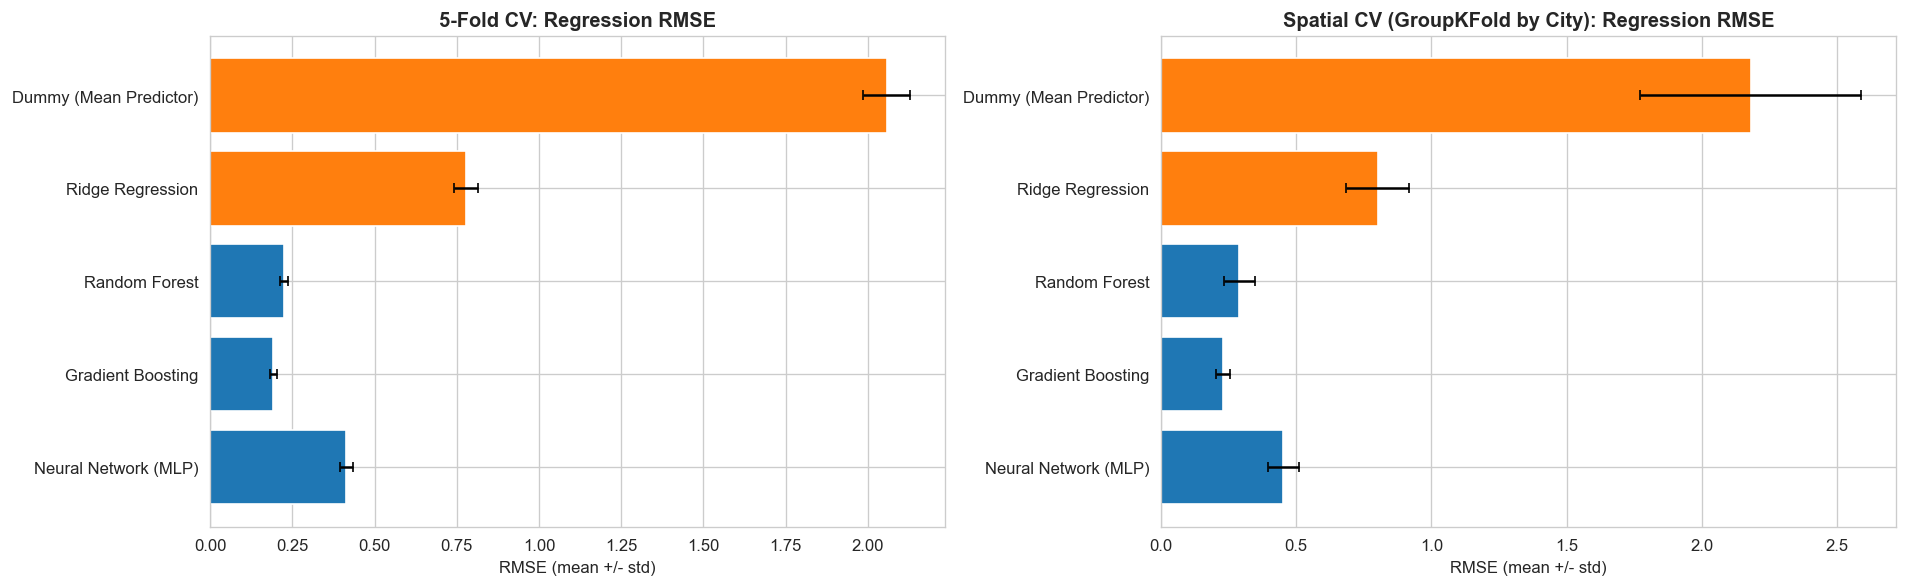

In [ ]:
# Regression bar charts
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
colors_r = ['#ff7f0e' if t == 'Baseline' else '#1f77b4' for t in cv_reg_df['Type']]

ax = axes[0]
ax.barh(cv_reg_df['Model'], cv_reg_df['_cv_rmse_mean'], xerr=cv_reg_df['_cv_rmse_std'],
        color=colors_r, edgecolor='white', capsize=3)
ax.set_xlabel('RMSE (mean +/- std)')
ax.set_title('5-Fold CV: Regression RMSE', fontweight='bold')
ax.invert_yaxis()

ax = axes[1]
ax.barh(cv_reg_df['Model'], cv_reg_df['_sp_rmse_mean'], xerr=cv_reg_df['_sp_rmse_std'],
        color=colors_r, edgecolor='white', capsize=3)
ax.set_xlabel('RMSE (mean +/- std)')
ax.set_title('Spatial CV (GroupKFold by City): Regression RMSE', fontweight='bold')
ax.invert_yaxis()

plt.tight_layout()
save_and_show('reg_cv_comparison.png')

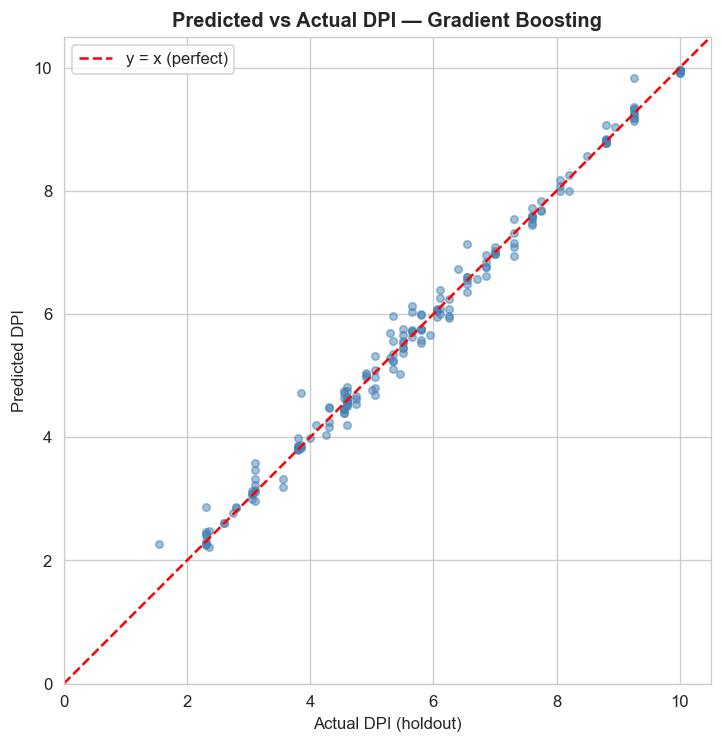

In [ ]:
# Scatter: Predicted vs Actual DPI (holdout, best regressor)
best_reg_name = min(primary_reg_res, key=lambda n: primary_reg_res[n]['rmse'])
y_pred_best = primary_reg_res[best_reg_name]['y_pred']

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(yr_test, y_pred_best, alpha=0.5, s=20, color='steelblue')
lims = [0, 10.5]
ax.plot(lims, lims, 'r--', linewidth=1.5, label='y = x (perfect)')
ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_xlabel('Actual DPI (holdout)')
ax.set_ylabel('Predicted DPI')
ax.set_title(f'Predicted vs Actual DPI — {best_reg_name}', fontweight='bold')
ax.set_aspect('equal')
ax.legend()
save_and_show('predicted_vs_actual_dpi.png')

## 9. Interpretability: Feature Importance

Feature importances from the Random Forest classifier and coefficient magnitudes
from Logistic Regression (where available).

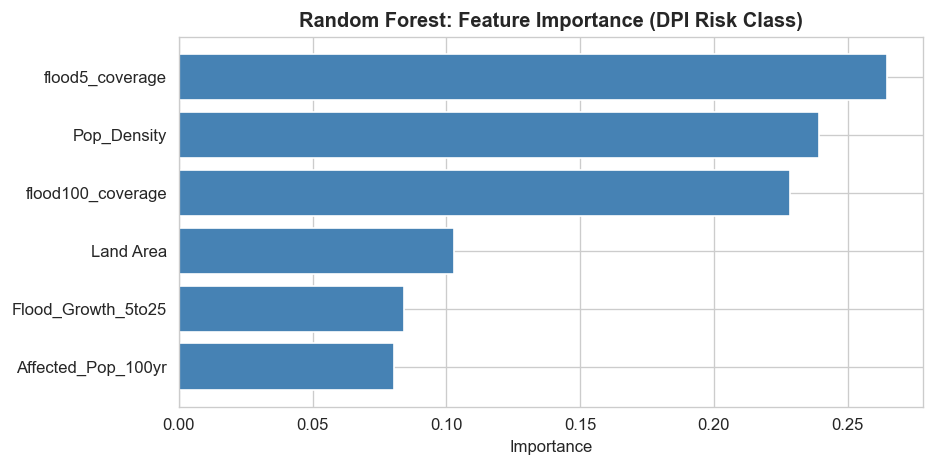

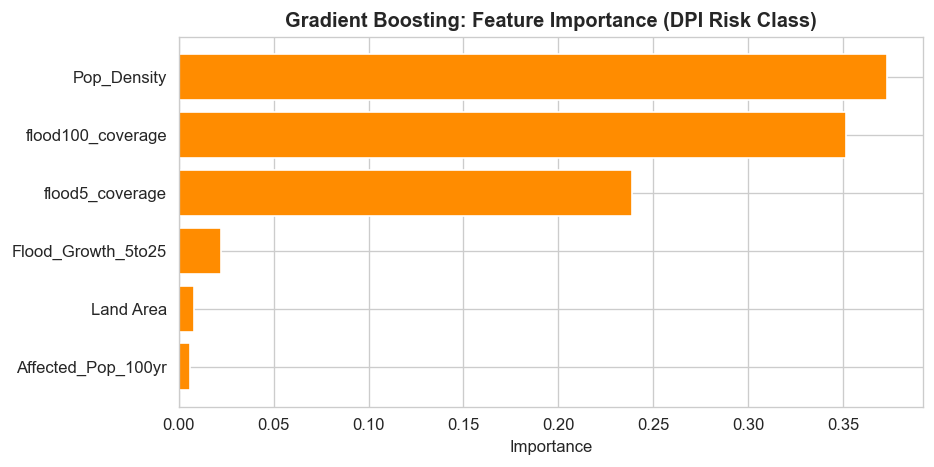

In [ ]:
# Random Forest feature importance 
rf_clf_pipe = primary_clf_res[MODEL_NAMES['rf']]['model']
rf_importances = rf_clf_pipe.named_steps['model'].feature_importances_
imp_df = pd.DataFrame({'Feature': FEATURE_COLS, 'Importance': rf_importances})
imp_df = imp_df.sort_values('Importance', ascending=True)

fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(imp_df['Feature'], imp_df['Importance'], color='steelblue', edgecolor='white')
ax.set_xlabel('Importance')
ax.set_title('Random Forest: Feature Importance (DPI Risk Class)', fontweight='bold')
save_and_show('feature_importance_rf.png')

# Gradient Boosting feature importance
gb_clf_pipe = primary_clf_res[MODEL_NAMES['gb']]['model']
gb_importances = gb_clf_pipe.named_steps['model'].feature_importances_
imp_gb = pd.DataFrame({'Feature': FEATURE_COLS, 'Importance': gb_importances})
imp_gb = imp_gb.sort_values('Importance', ascending=True)

fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(imp_gb['Feature'], imp_gb['Importance'], color='darkorange', edgecolor='white')
ax.set_xlabel('Importance')
ax.set_title('Gradient Boosting: Feature Importance (DPI Risk Class)', fontweight='bold')
save_and_show('feature_importance_gb.png')

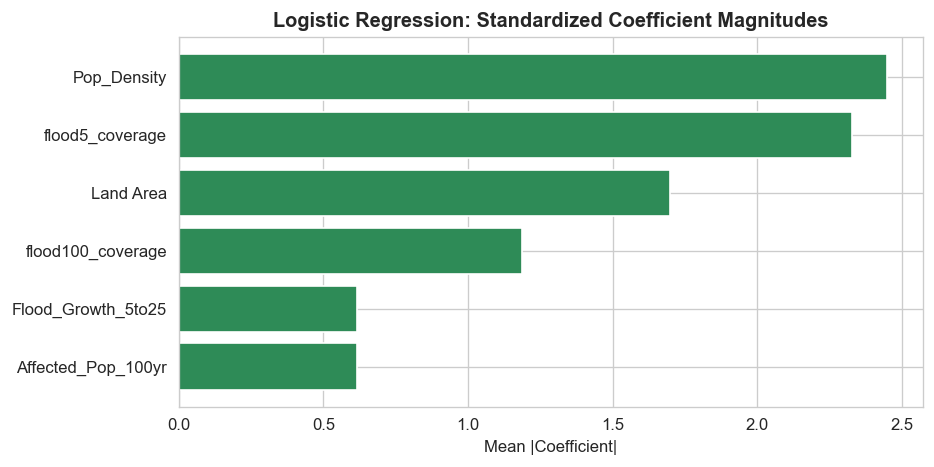

In [ ]:
# Logistic Regression: standardized coefficient magnitudes
try:
    lr_pipe = baseline_clf_res[MODEL_NAMES['logreg']]['model']
    lr_coefs = lr_pipe.named_steps['model'].coef_  # shape: (n_classes, n_features)
    # Mean absolute coefficient across classes
    mean_abs_coef = np.abs(lr_coefs).mean(axis=0)
    coef_df = pd.DataFrame({'Feature': FEATURE_COLS, '|Coefficient| (mean across classes)': mean_abs_coef})
    coef_df = coef_df.sort_values('|Coefficient| (mean across classes)', ascending=True)

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.barh(coef_df['Feature'], coef_df['|Coefficient| (mean across classes)'],
            color='seagreen', edgecolor='white')
    ax.set_xlabel('Mean |Coefficient|')
    ax.set_title('Logistic Regression: Standardized Coefficient Magnitudes', fontweight='bold')
    save_and_show('logreg_coefficients.png')
except Exception as e:
    print(f"Could not plot LR coefficients: {e}")

## 10. Sensitivity Analysis

Tests whether DPI **rankings** are robust to changes in the CSI component weights
and the CSI-vulnerability balance. Pairwise Spearman rank correlations across
12 weight configurations measure rank-order stability.

**Interpretation**: If all pairwise rho >= 0.90, the ranking is considered robust.
This means the *relative ordering* of barangays by risk is stable across reasonable
weight perturbations, even if absolute DPI values shift.

Configurations tested: 12
Pairwise Spearman rho: mean=0.9720 | min=0.9192
Conclusion: Rankings are ROBUST (min rho=0.9192 >= 0.90)


,Configuration,Spearman rho vs Default
0,CSI(50%/30%/20%)|Bal(50%/50%),0.9832
1,CSI(50%/30%/20%)|Bal(70%/30%),0.9806
2,CSI(40%/30%/30%)|Bal(60%/40%),0.9976
3,CSI(40%/30%/30%)|Bal(50%/50%),0.9819
4,CSI(40%/30%/30%)|Bal(70%/30%),0.9773
5,CSI(60%/25%/15%)|Bal(60%/40%),0.9980
6,CSI(60%/25%/15%)|Bal(50%/50%),0.9814
7,CSI(60%/25%/15%)|Bal(70%/30%),0.9748
8,CSI(33%/34%/33%)|Bal(60%/40%),0.9957
9,CSI(33%/34%/33%)|Bal(50%/50%),0.9811


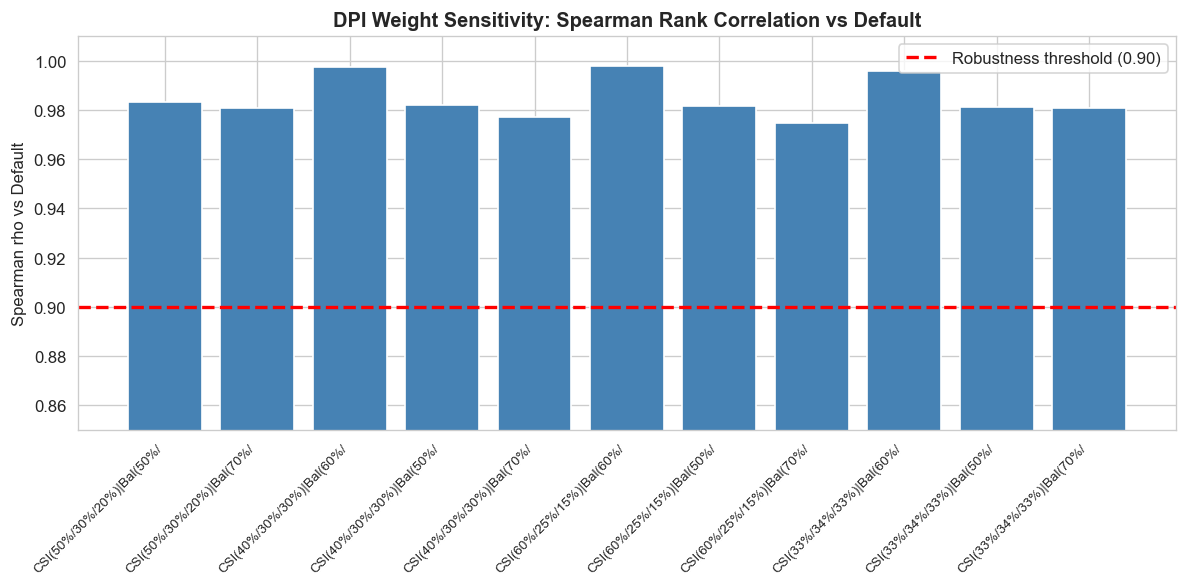

In [ ]:
# Weight configurations
s5  = df['Assessment_5yr_Score'].fillna(0)
s25 = df['Assessment_25yr_Score'].fillna(0)
s100 = df['Assessment_100yr_Score'].fillna(0)
vuln = df['Vulnerability_Score'].fillna(0)

csi_weight_configs = [
    (0.50, 0.30, 0.20),  # default
    (0.40, 0.30, 0.30),
    (0.60, 0.25, 0.15),
    (0.33, 0.34, 0.33),  # equal
]
balance_configs = [
    (0.60, 0.40),  # default
    (0.50, 0.50),
    (0.70, 0.30),
]

configs, dpis = [], []
for csi_w in csi_weight_configs:
    for bal in balance_configs:
        csi = s5 * csi_w[0] + s25 * csi_w[1] + s100 * csi_w[2]
        dpi = csi * bal[0] + vuln * bal[1]
        label = f"CSI({csi_w[0]:.0%}/{csi_w[1]:.0%}/{csi_w[2]:.0%})|Bal({bal[0]:.0%}/{bal[1]:.0%})"
        configs.append(label)
        dpis.append(dpi.values)

# Pairwise Spearman
rho_values = []
for i, j in combinations(range(len(configs)), 2):
    rho, _ = spearmanr(dpis[i], dpis[j])
    rho_values.append(rho)

min_rho  = np.min(rho_values)
mean_rho = np.mean(rho_values)

# Table: each config vs default 
sens_rows = []
default_dpi = dpis[0]
for idx in range(1, len(configs)):
    rho, _ = spearmanr(default_dpi, dpis[idx])
    sens_rows.append({'Configuration': configs[idx], 'Spearman rho vs Default': f'{rho:.4f}'})
sens_df = pd.DataFrame(sens_rows)

print(f"Configurations tested: {len(configs)}")
print(f"Pairwise Spearman rho: mean={mean_rho:.4f} | min={min_rho:.4f}")
if min_rho >= 0.90:
    print(f"Conclusion: Rankings are ROBUST (min rho={min_rho:.4f} >= 0.90)")
else:
    print(f"Conclusion: Rankings show SENSITIVITY (min rho={min_rho:.4f} < 0.90)")
display(sens_df)

# Plot: rho across configs
rho_vs_default = [float(r.split()[-1]) for _, r in sens_df[['Spearman rho vs Default']].itertuples()]
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(range(len(rho_vs_default)), rho_vs_default, color='steelblue', edgecolor='white')
ax.axhline(0.90, color='red', linestyle='--', linewidth=2, label='Robustness threshold (0.90)')
ax.set_xticks(range(len(rho_vs_default)))
ax.set_xticklabels([s[:25] for s in sens_df['Configuration']], rotation=45, ha='right', fontsize=8)
ax.set_ylabel('Spearman rho vs Default')
ax.set_title('DPI Weight Sensitivity: Spearman Rank Correlation vs Default', fontweight='bold')
ax.set_ylim(0.85, 1.01)
ax.legend()
plt.tight_layout()
save_and_show('sensitivity_analysis.png')

## 11. Validation & Consistency Checks

Since no external ground truth exists, validation takes the form of **construct
validation** — checking that DPI produces results consistent with domain knowledge
(e.g., higher flood coverage → higher DPI, higher density → higher DPI).

In [ ]:
# Monotonic sanity checks (Spearman) 
print("Monotonic Sanity Checks (Spearman correlations with DPI)")
dpi_vals = df['DPI'].values
sanity_rows = []
for col, expect in [('CSI', 'positive'), ('Pop_Density', 'positive'), ('flood100_coverage', 'positive')]:
    col_vals = pd.to_numeric(df[col], errors='coerce').values
    valid = ~(np.isnan(dpi_vals) | np.isnan(col_vals))
    if valid.sum() > 2:
        rho, pval = spearmanr(dpi_vals[valid], col_vals[valid])
        passed = rho > 0
        sanity_rows.append({'Variable': col, 'Expected': expect,
                            'Spearman rho': f'{rho:.4f}', 'p-value': f'{pval:.2e}', 'Pass': passed})

sanity_df = pd.DataFrame(sanity_rows)
display(sanity_df)

surprise = sanity_df[~sanity_df['Pass']]
if len(surprise):
    print("WARNING: Unexpected sign in the following correlations:")
    display(surprise)
else:
    print("All monotonic sanity checks passed (positive correlations as expected).")

Monotonic Sanity Checks (Spearman correlations with DPI)


,Variable,Expected,Spearman rho,p-value,Pass
0,CSI,positive,0.7859,5.44e-197,True
1,Pop_Density,positive,0.6742,6.39e-125,True
2,flood100_coverage,positive,0.7781,1.33e-190,True


All monotonic sanity checks passed (positive correlations as expected).


In [ ]:
# DPI Risk Distribution
dist = df['DPI_Risk_Class'].value_counts(normalize=True) * 100
print(f"DPI Risk Distribution: High {dist.get('High',0):.1f}% | Moderate {dist.get('Moderate',0):.1f}% | Low {dist.get('Low',0):.1f}%")

# Top/Bottom exemplars
ex_cols = ['Name', 'City', 'CSI', 'DPI', 'DPI_Risk_Class', 'Risk_Archetype']
print("\nTop 5 by DPI")
display(df.nlargest(5, 'DPI')[ex_cols])
print("\nBottom 5 by DPI")
display(df.nsmallest(5, 'DPI')[ex_cols])

# Outlier inspection
print("\nTop 5 Most Extreme Pop_Density")
ol_cols = ['Name', 'City', 'Population', 'Land Area', 'Pop_Density', 'CSI', 'DPI', 'DPI_Risk_Class']
ol_cols = [c for c in ol_cols if c in df.columns]
display(df.nlargest(5, 'Pop_Density')[ol_cols])
print("Note: Extreme Pop_Density results from small land area amplifying the ratio,")
print("not from data errors. Vulnerability score is capped at 10 regardless of magnitude.")

DPI Risk Distribution: High 32.9% | Moderate 52.4% | Low 14.7%

Top 5 by DPI


,Name,City,CSI,DPI,DPI_Risk_Class,Risk_Archetype
43,Barangay 50,Manila,10.0,10.0,High,HighDensity-HighExposure
45,Barangay 52,Manila,10.0,10.0,High,HighDensity-HighExposure
46,Barangay 53,Manila,10.0,10.0,High,HighDensity-HighExposure
51,Barangay 58,Manila,10.0,10.0,High,HighDensity-HighExposure
53,Barangay 60,Manila,10.0,10.0,High,HighDensity-HighExposure



Bottom 5 by DPI


,Name,City,CSI,DPI,DPI_Risk_Class,Risk_Archetype
574,Barangay 137,Caloocan,0.50,1.10,Low,LowDensity-LowExposure
294,Blue Ridge A,Quezon City,1.25,1.55,Low,LowDensity-LowExposure
505,Barangay 68,Caloocan,1.25,1.55,Low,LowDensity-LowExposure
450,Barangay 13,Caloocan,0.00,1.60,Low,LowDensity-LowExposure
478,Barangay 41,Caloocan,0.00,1.60,Low,LowDensity-LowExposure



Top 5 Most Extreme Pop_Density


,Name,City,Population,Land Area,Pop_Density,CSI,DPI,DPI_Risk_Class
92,Barangay 99,Manila,6310,12936.92,0.487751,10.00,10.00,High
775,Barangay 5,Pasay,6081,14147.95,0.429815,5.00,7.00,High
536,Barangay 99,Caloocan,13702,36749.99,0.372844,0.00,4.00,Moderate
518,Barangay 81,Caloocan,23432,67781.10,0.345701,3.75,6.25,Moderate
530,Barangay 93,Caloocan,19567,59960.77,0.326330,6.25,7.75,High


Note: Extreme Pop_Density results from small land area amplifying the ratio,
not from data errors. Vulnerability score is capped at 10 regardless of magnitude.


## 12. Exports

Generate final outputs:
- `final_methodology_aligned_results.xlsx` — per-barangay results table
- `final_risk_assessment.pdf` — comprehensive PDF report
- Verify all saved figures

In [ ]:
# Improvement over baselines (printed summary)
dummy_clf_f1 = baseline_clf_res[MODEL_NAMES['dummy_clf']]['f1w']
dummy_reg_rmse = baseline_reg_res[MODEL_NAMES['dummy_reg']]['rmse']
print("Improvement Over Baselines")
for name, res in primary_clf_res.items():
    print(f"  [{name}] F1 gain over Dummy: +{res['f1w'] - dummy_clf_f1:.2%}")
for name, res in primary_reg_res.items():
    print(f"  [{name}] RMSE reduction vs Dummy: {dummy_reg_rmse - res['rmse']:.4f}")

best_clf_name = max(primary_clf_res, key=lambda n: primary_clf_res[n]['f1w'])
best_reg_name = min(primary_reg_res, key=lambda n: primary_reg_res[n]['rmse'])
best_clf_model = primary_clf_res[best_clf_name]['model']
best_reg_model = primary_reg_res[best_reg_name]['model']
print(f"\nBest Classifier (by F1w): {best_clf_name}")
print(f"Best Regressor (by RMSE): {best_reg_name}")

# Full-dataset predictions (resubstitution)
full_pred_class = best_clf_model.predict(X)
full_pred_dpi   = best_reg_model.predict(X)
df['Predicted_Risk_Class'] = pd.Series(full_pred_class).map(INVERSE_ORDINAL_MAP).values
df['Predicted_DPI']        = np.clip(full_pred_dpi, 0, 10)

n_disagree = (df['Predicted_Risk_Class'] != df['DPI_Risk_Class']).sum()
print(f"\nResubstitution: {n_disagree}/{len(df)} disagreements ({(len(df)-n_disagree)/len(df):.1%} match)")
print("  (Includes training data — NOT a generalization metric. See CV scores above.)")

Improvement Over Baselines
  [Random Forest] F1 gain over Dummy: +59.15%
  [Gradient Boosting] F1 gain over Dummy: +59.68%
  [Neural Network (MLP)] F1 gain over Dummy: +57.53%
  [Random Forest] RMSE reduction vs Dummy: 1.8148
  [Gradient Boosting] RMSE reduction vs Dummy: 1.8511
  [Neural Network (MLP)] RMSE reduction vs Dummy: 1.6328

Best Classifier (by F1w): Gradient Boosting
Best Regressor (by RMSE): Gradient Boosting

Resubstitution: 8/935 disagreements (99.1% match)
  (Includes training data — NOT a generalization metric. See CV scores above.)


In [ ]:
# Recommendation function
def get_recommendation(row):
    """Archetype-aware recommendations (illustrative, not policy-validated)."""
    risk = row.get("DPI_Risk_Class", row.get("DPI_Risk_Class_Proxy", "Low"))
    archetype = str(row.get("Risk_Archetype", ""))

    if risk == "High":
        if "HighDensity" in archetype and "HighExposure" in archetype:
            return "Priority Zone: High density + high flood exposure. Immediate structural flood defenses and evacuation planning required."
        elif "HighDensity" in archetype and "LowExposure" in archetype:
            return "Priority Zone: High population density with elevated DPI. Focus on population management, early warning systems, and contingency planning."
        elif "LowDensity" in archetype and "HighExposure" in archetype:
            return "Priority Zone: Severe flood exposure despite lower density. Prioritize land-use restrictions and structural flood mitigation."
        else:
            return "Priority Zone: High logic-based DPI. Immediate intervention recommended."
    elif risk == "Moderate":
        if "HighExposure" in archetype:
            return "Watch Zone: Moderate DPI with significant flood exposure. Monitor and prepare preemptive drainage/infrastructure improvements."
        elif "HighDensity" in archetype:
            return "Watch Zone: Moderate DPI with high population density. Strengthen community preparedness and early warning coverage."
        else:
            return "Watch Zone: Moderate risk. Continue monitoring non-linear risk factors and seasonal flood patterns."
    else:
        if "HighExposure" in archetype:
            return "Low Priority overall, but notable flood exposure detected. Periodic review recommended."
        else:
            return "Low Priority: Maintenance and routine monitoring only."

# Export Excel 
df["Recommendation"] = df.apply(get_recommendation, axis=1)
output_cols = ['Name', 'City', 'Pop_Density', 'CSI', 'DPI', 'DPI_Risk_Class',
               'Risk_Archetype', 'Predicted_Risk_Class', 'Predicted_DPI', 'Recommendation']
for col in output_cols:
    if col not in df.columns:
        df[col] = "N/A"

df[output_cols].to_excel("final_methodology_aligned_results.xlsx", index=False)
print("Excel exported: final_methodology_aligned_results.xlsx")

Excel exported: final_methodology_aligned_results.xlsx


In [ ]:
# Generate PDF report
# Build pipeline_results dict for PDF (uses pre-computed results — no re-training)
cv_clf_results_dict = {}
for name, mdl in all_clf_cv_models.items():
    m1, m2 = clone(mdl), clone(mdl)
    is_ord = 'Ordinal Ridge' in name
    sw = cross_val_score(m1, X, y_class, cv=skf,
                         scoring=_ordinal_ridge_f1w if is_ord else 'f1_weighted')
    sm = cross_val_score(m2, X, y_class, cv=skf,
                         scoring=_ordinal_ridge_f1m if is_ord else 'f1_macro')
    cv_clf_results_dict[name] = {'f1w': sw, 'f1m': sm}

pipeline_results = {
    'y_class_test': yc_test, 'y_reg_test': yr_test,
    'all_clf_test': {}, 'all_reg_test': {},
    'cv_clf': cv_clf_results_dict, 'cv_reg': cv_reg_results_dict,
}
for name, res in baseline_clf_res.items():
    pipeline_results['all_clf_test'][name] = {
        'acc': res['acc'], 'bal_acc': res['bal_acc'], 'f1': res['f1w'],
        'f1_macro': res['f1_macro'], 'y_pred': res['y_pred'], 'type': 'Baseline'}
for name, res in primary_clf_res.items():
    pipeline_results['all_clf_test'][name] = {
        'acc': res['acc'], 'bal_acc': res['bal_acc'], 'f1': res['f1w'],
        'f1_macro': res['f1_macro'], 'y_pred': res['y_pred'], 'type': 'Primary'}
for name, res in baseline_reg_res.items():
    pipeline_results['all_reg_test'][name] = {
        'rmse': res['rmse'], 'mae': res['mae'], 'y_pred': res['y_pred'], 'type': 'Baseline'}
for name, res in primary_reg_res.items():
    pipeline_results['all_reg_test'][name] = {
        'rmse': res['rmse'], 'mae': res['mae'], 'y_pred': res['y_pred'], 'type': 'Primary'}

print("Pipeline results assembled for PDF report.")

Pipeline results assembled for PDF report.


In [ ]:
# PDF report generation
print("Generating PDF Report...")
try:
    pdf = FPDF()
    pdf.add_page()
    pw = pdf.w - pdf.l_margin - pdf.r_margin

    pdf.set_font("Helvetica", style="B", size=16)
    pdf.cell(pw, 10, text="Disaster Risk Priority Report (NCR)", align="C",
             new_x=XPos.LMARGIN, new_y=YPos.NEXT)
    pdf.ln(6)

    # Section 1: Summary Statistics
    pdf.set_font("Helvetica", style="B", size=13)
    pdf.cell(pw, 8, text="1. Summary Statistics", new_x=XPos.LMARGIN, new_y=YPos.NEXT)
    pdf.ln(2)
    total = len(df)
    dist_pdf = df["DPI_Risk_Class"].value_counts()
    pdf.set_font("Helvetica", size=10)
    pdf.cell(pw, 7, text=f"Total Barangays Analyzed: {total}", new_x=XPos.LMARGIN, new_y=YPos.NEXT)
    for cat in ["High", "Moderate", "Low"]:
        cnt = dist_pdf.get(cat, 0)
        pdf.cell(pw, 7, text=f"  {cat} Risk: {cnt} ({cnt/total:.1%})", new_x=XPos.LMARGIN, new_y=YPos.NEXT)
    pdf.cell(pw, 7, text=f"DPI  mean={df['DPI'].mean():.2f}  median={df['DPI'].median():.2f}  "
                          f"std={df['DPI'].std():.2f}  min={df['DPI'].min():.2f}  max={df['DPI'].max():.2f}",
             new_x=XPos.LMARGIN, new_y=YPos.NEXT)
    pdf.ln(4)

    # Section 2: Top 10
    pdf.set_font("Helvetica", style="B", size=13)
    pdf.cell(pw, 8, text="2. Top 10 Highest-DPI Barangays", new_x=XPos.LMARGIN, new_y=YPos.NEXT)
    pdf.ln(2)
    col_w = [50, 35, 20, 20, 25, 40]
    headers_pdf = ["Barangay", "City", "DPI", "CSI", "Risk Class", "Archetype"]
    pdf.set_font("Helvetica", style="B", size=9)
    for i, h in enumerate(headers_pdf):
        pdf.cell(col_w[i], 7, h, 1)
    pdf.ln()
    pdf.set_font("Helvetica", size=8)
    top10 = df.sort_values("DPI", ascending=False).head(10)
    for _, r in top10.iterrows():
        vals = [str(r.get("Name", ""))[:22], str(r.get("City", "N/A"))[:14],
                f"{r.get('DPI', 0):.2f}", f"{r.get('CSI', 0):.2f}",
                str(r.get("DPI_Risk_Class", "N/A")), str(r.get("Risk_Archetype", "N/A"))[:18]]
        for i, v in enumerate(vals):
            pdf.cell(col_w[i], 7, v, 1)
        pdf.ln()
    pdf.ln(4)

    # Section 3: Clustering diag
    pdf.set_font("Helvetica", style="B", size=13)
    pdf.cell(pw, 8, text="3. K-Means Clustering Diagnostics", new_x=XPos.LMARGIN, new_y=YPos.NEXT)
    pdf.ln(2)
    pdf.set_font("Helvetica", size=10)
    try:
        X_d = df[FEATURE_COLS].apply(pd.to_numeric, errors="coerce")
        X_sc2 = StandardScaler().fit_transform(SimpleImputer(strategy="mean").fit_transform(X_d))
        c_d = df["Cluster_Group"].values
        pdf.cell(pw, 7, text=f"Number of Clusters (K): {len(set(c_d))}", new_x=XPos.LMARGIN, new_y=YPos.NEXT)
        pdf.cell(pw, 7, text=f"Silhouette Score: {silhouette_score(X_sc2, c_d):.4f}", new_x=XPos.LMARGIN, new_y=YPos.NEXT)
        pdf.cell(pw, 7, text=f"Davies-Bouldin Index: {davies_bouldin_score(X_sc2, c_d):.4f}", new_x=XPos.LMARGIN, new_y=YPos.NEXT)
        pdf.cell(pw, 7, text=f"Calinski-Harabasz Index: {calinski_harabasz_score(X_sc2, c_d):.2f}", new_x=XPos.LMARGIN, new_y=YPos.NEXT)
    except Exception:
        pdf.cell(pw, 7, text="Could not compute cluster diagnostics.", new_x=XPos.LMARGIN, new_y=YPos.NEXT)
    if "Risk_Archetype" in df.columns:
        pdf.ln(2)
        pdf.set_font("Helvetica", style="B", size=10)
        pdf.cell(pw, 7, text="Archetype Distribution:", new_x=XPos.LMARGIN, new_y=YPos.NEXT)
        pdf.set_font("Helvetica", size=9)
        for arch, cnt in df["Risk_Archetype"].value_counts().items():
            pdf.cell(pw, 6, text=f"  {arch}: {cnt} ({cnt/total:.1%})", new_x=XPos.LMARGIN, new_y=YPos.NEXT)
    pdf.ln(4)

    # Section 4: Model Performance
    pdf.add_page()
    pdf.set_font("Helvetica", style="B", size=13)
    pdf.cell(pw, 8, text="4. Supervised Model Performance (Agreement with DPI)",
             new_x=XPos.LMARGIN, new_y=YPos.NEXT)
    pdf.ln(2)
    pdf.set_font("Helvetica", size=9)
    pdf.cell(pw, 6, text="Note: Models predict index-derived targets (DPI). High accuracy reflects learnability",
             new_x=XPos.LMARGIN, new_y=YPos.NEXT)
    pdf.cell(pw, 6, text="of the deterministic benchmark, not real-world flood prediction.",
             new_x=XPos.LMARGIN, new_y=YPos.NEXT)
    pdf.ln(3)
    try:
        pr = pipeline_results
        cv_clf_pdf = pr["cv_clf"]
        cv_reg_pdf = pr["cv_reg"]
        all_clf_t = pr["all_clf_test"]
        all_reg_t = pr["all_reg_test"]
        yc_te_pdf = pr["y_class_test"]

        # CV Performance table
        pdf.set_font("Helvetica", style="B", size=10)
        pdf.cell(pw, 7, text="Primary: 5-Fold Stratified Cross-Validated Performance",
                 new_x=XPos.LMARGIN, new_y=YPos.NEXT)
        pdf.ln(1)
        cv_cw = [40, 45, 45, 25]
        pdf.set_font("Helvetica", style="B", size=8)
        for i, h in enumerate(["Model", "CV F1w (mean+/-std)", "CV F1macro (mean+/-std)", "Type"]):
            pdf.cell(cv_cw[i], 7, h, 1)
        pdf.ln()
        pdf.set_font("Helvetica", size=8)
        for cv_key, cv_data in cv_clf_pdf.items():
            if not cv_key.startswith("(P)"):
                continue
            dn = cv_key[4:]
            sw2, sm2 = cv_data["f1w"], cv_data["f1m"]
            pdf.cell(cv_cw[0], 7, dn, 1)
            pdf.cell(cv_cw[1], 7, f"{sw2.mean():.4f} +/- {sw2.std():.4f}", 1)
            pdf.cell(cv_cw[2], 7, f"{sm2.mean():.4f} +/- {sm2.std():.4f}", 1)
            pdf.cell(cv_cw[3], 7, "Primary", 1)
            pdf.ln()
        pdf.ln(2)

        cv_rw = [40, 45, 45, 25]
        pdf.set_font("Helvetica", style="B", size=8)
        for i, h in enumerate(["Model", "CV RMSE (mean+/-std)", "CV MAE (mean+/-std)", "Type"]):
            pdf.cell(cv_rw[i], 7, h, 1)
        pdf.ln()
        pdf.set_font("Helvetica", size=8)
        for cv_key, cv_data in cv_reg_pdf.items():
            if not cv_key.startswith("(P)"):
                continue
            dn = cv_key[4:]
            sr, sm2 = cv_data["rmse"], cv_data["mae"]
            pdf.cell(cv_rw[0], 7, dn, 1)
            pdf.cell(cv_rw[1], 7, f"{-sr.mean():.4f} +/- {sr.std():.4f}", 1)
            pdf.cell(cv_rw[2], 7, f"{-sm2.mean():.4f} +/- {sm2.std():.4f}", 1)
            pdf.cell(cv_rw[3], 7, "Primary", 1)
            pdf.ln()
        pdf.ln(4)

        # Single-split table
        pdf.set_font("Helvetica", style="B", size=10)
        pdf.cell(pw, 7, text="Secondary: Single-Split Test Set Performance (80/20)",
                 new_x=XPos.LMARGIN, new_y=YPos.NEXT)
        pdf.ln(2)
        pdf.set_font("Helvetica", style="B", size=10)
        pdf.cell(pw, 7, text="Classification (target: DPI_Risk_Class)", new_x=XPos.LMARGIN, new_y=YPos.NEXT)
        c_w = [38, 22, 22, 22, 22, 22]
        pdf.set_font("Helvetica", style="B", size=7)
        for i, h in enumerate(["Model", "Acc", "BalAcc", "F1w", "F1macro", "Type"]):
            pdf.cell(c_w[i], 7, h, 1)
        pdf.ln()
        pdf.set_font("Helvetica", size=7)
        for name2, res2 in all_clf_t.items():
            for i, v in enumerate([name2, f"{res2['acc']:.2%}", f"{res2['bal_acc']:.2%}",
                                   f"{res2['f1']:.2%}", f"{res2['f1_macro']:.2%}", res2["type"]]):
                pdf.cell(c_w[i], 7, v, 1)
            pdf.ln()
        pdf.ln(3)

        # Confusion matrices
        pdf.set_font("Helvetica", style="B", size=10)
        pdf.cell(pw, 7, text="Confusion Matrices (held-out test split)", new_x=XPos.LMARGIN, new_y=YPos.NEXT)
        pdf.set_font("Helvetica", size=8)
        pdf.cell(pw, 5, text="Rows = true, Cols = predicted. [Low(0), Moderate(1), High(2)]",
                 new_x=XPos.LMARGIN, new_y=YPos.NEXT)
        pdf.ln(1)
        prim_names = [n for n, r in all_clf_t.items() if r["type"] == "Primary"]
        best_pn = max(prim_names, key=lambda n: all_clf_t[n]["f1"])
        for cname in [MODEL_NAMES["dummy_clf"], MODEL_NAMES["logreg"],
                      MODEL_NAMES["dt2"], MODEL_NAMES["ord_ridge"], best_pn]:
            if cname in all_clf_t:
                cm2 = confusion_matrix(yc_te_pdf, all_clf_t[cname]["y_pred"], labels=[0, 1, 2])
                pdf.cell(pw, 6, text=f"{cname}: {cm2.tolist()}", new_x=XPos.LMARGIN, new_y=YPos.NEXT)
        pdf.ln(3)

        # Regression table
        pdf.set_font("Helvetica", style="B", size=10)
        pdf.cell(pw, 7, text="Regression (target: DPI score)", new_x=XPos.LMARGIN, new_y=YPos.NEXT)
        r_w = [55, 35, 35, 25]
        pdf.set_font("Helvetica", style="B", size=7)
        for i, h in enumerate(["Model", "RMSE", "MAE", "Type"]):
            pdf.cell(r_w[i], 7, h, 1)
        pdf.ln()
        pdf.set_font("Helvetica", size=7)
        for name2, res2 in all_reg_t.items():
            for i, v in enumerate([name2, f"{res2['rmse']:.4f}", f"{res2['mae']:.4f}", res2["type"]]):
                pdf.cell(r_w[i], 7, v, 1)
            pdf.ln()
    except Exception as e:
        pdf.cell(pw, 7, text=f"Could not generate model tables: {e}", new_x=XPos.LMARGIN, new_y=YPos.NEXT)
    pdf.ln(5)

    # Section 5: Per-category details
    pdf.set_font("Helvetica", style="B", size=13)
    pdf.cell(pw, 8, text="5. Risk Category Details (Top 10 per Category)",
             new_x=XPos.LMARGIN, new_y=YPos.NEXT)
    pdf.ln(2)
    for category in ["High", "Moderate", "Low"]:
        pdf.set_font("Helvetica", style="B", size=11)
        pdf.cell(pw, 8, text=f"{category} Risk", new_x=XPos.LMARGIN, new_y=YPos.NEXT)
        pdf.ln(1)
        t_w = [45, 30, 18, 18, 22, 57]
        pdf.set_font("Helvetica", style="B", size=8)
        for i, h in enumerate(["Barangay", "City", "DPI", "CSI", "Archetype", "Recommendation"]):
            pdf.cell(t_w[i], 7, h, 1)
        pdf.ln()
        pdf.set_font("Helvetica", size=7)
        subset = df[df["DPI_Risk_Class"] == category].sort_values("DPI", ascending=False).head(10)
        for _, row in subset.iterrows():
            rv = [str(row.get("Name", ""))[:20], str(row.get("City", "N/A"))[:13],
                  f"{row.get('DPI', 0):.2f}", f"{row.get('CSI', 0):.2f}",
                  str(row.get("Risk_Archetype", "N/A"))[:10],
                  str(row.get("Recommendation", ""))[:30]]
            for i, v in enumerate(rv):
                pdf.cell(t_w[i], 6, v, 1)
            pdf.ln()
        pdf.ln(3)

    pdf.output("final_risk_assessment.pdf")
    print("PDF Report saved: final_risk_assessment.pdf")
except Exception as e:
    print(f"Could not generate PDF: {e}")

Generating PDF Report...
PDF Report saved: final_risk_assessment.pdf


In [ ]:
# Verify saved outputs
import os
expected_files = [
    'final_methodology_aligned_results.xlsx',
    'final_risk_assessment.pdf',
    'kmeans_cluster_chart.png',
] + SAVED_FIGURES

print("Saved outputs verification:")
for f in sorted(set(expected_files)):
    exists = os.path.exists(f)
    size = os.path.getsize(f) if exists else 0
    status = f"OK ({size:,} bytes)" if exists else "MISSING"
    print(f"  {f}: {status}")

Saved outputs verification:
  archetype_distribution.png: OK (52,820 bytes)
  ari_stability.png: OK (29,730 bytes)
  clf_cv_comparison.png: OK (72,295 bytes)
  confusion_matrices.png: OK (49,202 bytes)
  dpi_class_distribution.png: OK (25,135 bytes)
  dpi_histogram_thresholds.png: OK (45,010 bytes)
  feature_boxplots.png: OK (61,449 bytes)
  feature_distributions.png: OK (178,699 bytes)
  feature_importance_gb.png: OK (44,947 bytes)
  feature_importance_rf.png: OK (43,268 bytes)
  final_methodology_aligned_results.xlsx: OK (65,509 bytes)
  final_risk_assessment.pdf: OK (7,168 bytes)
  kmeans_cluster_chart.png: OK (421,851 bytes)
  logreg_coefficients.png: OK (45,811 bytes)
  predicted_vs_actual_dpi.png: OK (68,864 bytes)
  reg_cv_comparison.png: OK (60,739 bytes)
  sensitivity_analysis.png: OK (77,379 bytes)
  silhouette_vs_k.png: OK (57,357 bytes)


## 13. Deviations from Original Script

| # | Change | Reason |
|---|--------|--------|
| 1 | Added `Pop_Density vs flood100_coverage` scatter plot | Required by defense spec; matches archetype label logic (archetypes use flood100_coverage centroids, not CSI) |
| 2 | Added explicit histogram + KDE charts for all key features | Defense visualization requirement |
| 3 | Added boxplots for density/coverage outlier visibility | Defense visualization requirement |
| 4 | Added predicted-vs-actual DPI scatter for best regressor | Defense visualization requirement |
| 5 | Added Logistic Regression coefficient plot | Defense interpretability requirement |
| 6 | Added Gradient Boosting feature importance plot alongside RF | Additional interpretability |
| 7 | Moved `from collections import Counter` to top-level imports | Clean import ordering |
| 8 | Added `save_and_show()` helper to save + display every figure | Reproducibility requirement |

**No changes** were made to any formulas, thresholds, model hyperparameters, scoring
functions, cross-validation protocols, or sensitivity analysis logic. All mathematical
operations are identical to the original `ml-backend.py`.